# Visualisation of DoRothEA results

# `final_annot_v9` annotation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [4]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_

In [5]:
TF_activities = {}

# up and down reg separately
TF_activities_upreg = {}
TF_activities_downreg = {}

comparisons = ['VCT_CCC','EVT_1_like','EVT_early','EVT_mid','EVT_late','iEVT'
              ]

for comparison in comparisons:
    print(comparison)
    TF_activities[comparison] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/Trophoblast_Organoids/202105_joint_analysis/no_cytokine_analysis/TF_activities/results/20220218/20220218_TF_activities_' + comparison + '.csv',
                                           sep='\t')
    
    # add a score (A, B, .., F) and TF_name
    TF_activities[comparison]['score'] = [elem.split('_')[1] for elem in TF_activities[comparison]['Regulon']]
    TF_activities[comparison]['TF_name'] = [elem.split('_')[0] for elem in TF_activities[comparison]['Regulon']]
    
    # only taking TFs that are active (NES > 0)
    TF_activities_upreg[comparison] = TF_activities[comparison][TF_activities[comparison]['NES'] > 0]
    # also taking only those that have FDR < 0.05, like in DE
    TF_activities_upreg[comparison] = TF_activities_upreg[comparison][TF_activities_upreg[comparison]['FDR'] < 0.05]
    
    
    # only taking TFs that are active (NES < 0)
    TF_activities_downreg[comparison] = TF_activities[comparison][TF_activities[comparison]['NES'] < 0]
    # also taking only those that have FDR < 0.05, like in DE
    TF_activities_downreg[comparison] = TF_activities_downreg[comparison][TF_activities_downreg[comparison]['FDR'] < 0.05]
        
    print('number of TFs overall:', len(TF_activities[comparison]))
    print('number of significant upreg active TFs:', len(TF_activities_upreg[comparison]),'\n')
    print('number of significant downreg active TFs:', len(TF_activities_downreg[comparison]),'\n')
    

VCT_CCC
number of TFs overall: 1385
number of significant upreg active TFs: 452 

number of significant downreg active TFs: 185 

EVT_1_like
number of TFs overall: 1385
number of significant upreg active TFs: 253 

number of significant downreg active TFs: 200 

EVT_early
number of TFs overall: 1385
number of significant upreg active TFs: 134 

number of significant downreg active TFs: 298 

EVT_mid
number of TFs overall: 1385
number of significant upreg active TFs: 174 

number of significant downreg active TFs: 556 

EVT_late
number of TFs overall: 1385
number of significant upreg active TFs: 121 

number of significant downreg active TFs: 314 

iEVT
number of TFs overall: 1385
number of significant upreg active TFs: 716 

number of significant downreg active TFs: 152 



In [6]:
TF_activities['iEVT']['score'].value_counts()

E     990
C     135
B      94
D      62
A      53
AA     51
Name: score, dtype: int64

## Adding another layer of evidence: differential expression

In [7]:
# all TF regulons list, same in all tables
TFs_list = list(TF_activities['iEVT']['TF_name'])

In [8]:
len(TFs_list)

1385

In [9]:
# reading in tables of DE for ct-vs-previous_ct comparisons

DEGs = {}

DEGs_significant_upreg = {}

DEGs_significant_upreg_TFs = {} # intersection of significant upreg DEGs with all TFs list

DEGs_significant_downreg = {}

DEGs_significant_downreg_TFs = {} # intersection of significant downreg DEGs with all TFs list

for comparison in comparisons:
    print(comparison)
    DEGs[comparison] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/Trophoblast_Organoids/202105_joint_analysis/no_cytokine_analysis/limma_DEGs/20220218_with_donor_covariate/20220218_' + comparison + '_no_cytokines_limma_DEGs.csv', 
                                   index_col=0)
    DEGs_significant_upreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_upreg[comparison] = DEGs_significant_upreg[comparison][DEGs_significant_upreg[comparison]['logFC'] > 0]
    
    DEGs_significant_upreg_TFs[comparison] = DEGs_significant_upreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_upreg[comparison].index)),:]
    
    
    DEGs_significant_downreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_downreg[comparison] = DEGs_significant_downreg[comparison][DEGs_significant_downreg[comparison]['logFC'] < 0]
    
    DEGs_significant_downreg_TFs[comparison] = DEGs_significant_downreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_downreg[comparison].index)),:]
    
    
    print('number of DEGs overall:', len(DEGs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_upreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_upreg_TFs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_downreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_downreg_TFs[comparison]),'\n')


VCT_CCC
number of DEGs overall: 22091
number of significant upreg DEGs: 6016
number of significant upreg DEGs that are TFs: 469
number of significant upreg DEGs: 5059
number of significant upreg DEGs that are TFs: 230 

EVT_1_like
number of DEGs overall: 21320
number of significant upreg DEGs: 4896
number of significant upreg DEGs that are TFs: 199
number of significant upreg DEGs: 1833
number of significant upreg DEGs that are TFs: 142 

EVT_early
number of DEGs overall: 21591
number of significant upreg DEGs: 3571
number of significant upreg DEGs that are TFs: 247
number of significant upreg DEGs: 5516
number of significant upreg DEGs that are TFs: 291 

EVT_mid
number of DEGs overall: 21450
number of significant upreg DEGs: 3809
number of significant upreg DEGs that are TFs: 126
number of significant upreg DEGs: 6261
number of significant upreg DEGs that are TFs: 536 

EVT_late
number of DEGs overall: 20760
number of significant upreg DEGs: 2539
number of significant upreg DEGs that

In [10]:
DEGs_significant_upreg['iEVT']

logFC        P.Value      adj.P.Val  AveExpr_cluster  \
Gene                                                               
CASQ1    0.475264  4.788805e-300  3.019124e-297         0.533842   
PLXNB2   1.181117  2.059910e-286  1.045279e-283         1.637601   
COL27A1  1.229219  1.048511e-215  3.462583e-213         1.724581   
MAMDC2   1.219182  1.011178e-185  2.963036e-183         1.665370   
LIFR     1.486159  1.453128e-184  4.198934e-182         2.610611   
...           ...            ...            ...              ...   
CLCN5    0.020950   1.666608e-02   4.980434e-02         0.048633   
AP5M1    0.039010   1.667058e-02   4.981064e-02         0.126089   
DDX54    0.060273   1.667430e-02   4.981458e-02         0.258519   
FAM135A  0.023014   1.669014e-02   4.985474e-02         0.052640   
ZNF320   0.010460   1.671175e-02   4.991214e-02         0.014772   

         AveExpr_rest  percentExpr_cluster  percentExpr_rest  
Gene                                                          
CASQ1        0.030443             0.563291          0.076923  
PLXNB2       0.270340             0.936709          0.401923  
COL27A1      0.362342             0.924051          0.473521  
MAMDC2       0.249619             0.810127          0.272633  
LIFR         0.929825             0.981013          0.830917  
...               ...                  ...               ...  
CLCN5        0.020902             0.094937          0.048964  
AP5M1        0.077968             0.208861          0.176923  
DDX54        0.214687             0.398734          0.410947  
FAM135A      0.025804             0.094937          0.060207  
ZNF320       0.005063             0.031646          0.011982  

[5159 rows x 7 columns]

## First attempt: let's take a union of all the TFs DE according to limma and those that are active according to DoRothEA

In [11]:
TFs_upregulated_per_comparison = {}

TFs_downregulated_per_comparison = {}

for comparison in comparisons:
    print(comparison)
    
    
    TFs_upregulated_per_comparison[comparison] = pd.DataFrame(index = set(list(DEGs_significant_upreg_TFs[comparison].index) + list(TF_activities_upreg[comparison]['TF_name'])))
    TFs_downregulated_per_comparison[comparison] = pd.DataFrame(index = set(list(DEGs_significant_downreg_TFs[comparison].index) + list(TF_activities_downreg[comparison]['TF_name'])))

    TFs_upregulated_per_comparison[comparison]['Avg_expr'] = ['na']*len(TFs_upregulated_per_comparison[comparison])
    TFs_downregulated_per_comparison[comparison]['Avg_expr'] = ['na']*len(TFs_downregulated_per_comparison[comparison])
    
    TFs_upregulated_per_comparison[comparison]['is_DE_limma'] = ['na']*len(TFs_upregulated_per_comparison[comparison])
    TFs_upregulated_per_comparison[comparison]['is_DA_dorothea'] = ['na']*len(TFs_upregulated_per_comparison[comparison]) # DA for differentially active

    TFs_downregulated_per_comparison[comparison]['is_DE_limma'] = ['na']*len(TFs_downregulated_per_comparison[comparison])
    TFs_downregulated_per_comparison[comparison]['is_DA_dorothea'] = ['na']*len(TFs_downregulated_per_comparison[comparison]) # DA for differentially active

    
    # add whether TF is coming from limma DE or DoRothEA or both
    TFs_upregulated_per_comparison[comparison]['is_DE_limma'] = ['yes' if TF in list(DEGs_significant_upreg_TFs[comparison].index) else 'no' for TF in TFs_upregulated_per_comparison[comparison].index]
    TFs_upregulated_per_comparison[comparison]['is_DA_dorothea'] = ['yes' if TF in list(TF_activities_upreg[comparison]['TF_name']) else 'no' for TF in TFs_upregulated_per_comparison[comparison].index]

    # add whether TF is coming from limma DE or DoRothEA or both
    TFs_downregulated_per_comparison[comparison]['is_DE_limma'] = ['yes' if TF in list(DEGs_significant_downreg_TFs[comparison].index) else 'no' for TF in TFs_downregulated_per_comparison[comparison].index]
    TFs_downregulated_per_comparison[comparison]['is_DA_dorothea'] = ['yes' if TF in list(TF_activities_downreg[comparison]['TF_name']) else 'no' for TF in TFs_downregulated_per_comparison[comparison].index]
 
    
    
    # is the TF DE and DA (by either dorothea or chromvar)
    TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] = ['yes' if (DE == 'yes' and DA_dorothea == 'yes') else 'no' for DE,DA_dorothea in zip(TFs_upregulated_per_comparison[comparison]['is_DE_limma'],
                                                                                                                                                                TFs_upregulated_per_comparison[comparison]['is_DA_dorothea'])]
    
    # is the TF DE and DA (by either dorothea or chromvar)
    TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'] = ['yes' if (DE == 'yes' and DA_dorothea == 'yes') else 'no' for DE,DA_dorothea in zip(TFs_downregulated_per_comparison[comparison]['is_DE_limma'],
                                                                                                                                                                TFs_downregulated_per_comparison[comparison]['is_DA_dorothea'])]
    
    
    print('number of TFs upregulated here:', len(TFs_upregulated_per_comparison[comparison]))
    print('number of TFs downregulated here:', len(TFs_downregulated_per_comparison[comparison]))
    
    # necessary for CellSign
    TFs_upregulated_per_comparison[comparison]['cluster'] = comparison.split('_vs_')[0]
    TFs_upregulated_per_comparison[comparison]['ID'] = [cluster + '_' + TF for cluster,TF in zip(TFs_upregulated_per_comparison[comparison]['cluster'],
                                                                                               TFs_upregulated_per_comparison[comparison].index)]
    
    # necessary for CellSign
    TFs_downregulated_per_comparison[comparison]['cluster'] = comparison.split('_vs_')[0]
    TFs_downregulated_per_comparison[comparison]['ID'] = [cluster + '_' + TF for cluster,TF in zip(TFs_downregulated_per_comparison[comparison]['cluster'],
                                                                                               TFs_downregulated_per_comparison[comparison].index)]
    
    
    print('is_DE_and_DA upreg', np.unique(TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'], return_counts=True), '\n')
    print('is_DE_and_DA downreg', np.unique(TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'], return_counts=True), '\n')
   
    
    for TF in TFs_upregulated_per_comparison[comparison].index:
        #print(TF)
        
        # add average expression from overall unfiltered limma table if it's there
        if TF in DEGs[comparison].index: # if it's expressed enough according to limma
            TFs_upregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = DEGs[comparison].loc[TF,'AveExpr_cluster']
        else:
            TFs_upregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = 'not_enough_cells_expr_limma'
            
    for TF in TFs_downregulated_per_comparison[comparison].index:
        #print(TF)
        
        # add average expression from overall unfiltered limma table if it's there
        if TF in DEGs[comparison].index: # if it's expressed enough according to limma
            TFs_downregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = DEGs[comparison].loc[TF,'AveExpr_cluster']
        else:
            TFs_downregulated_per_comparison[comparison].loc[TF,'Avg_expr'] = 'not_enough_cells_expr_limma'
            
            
            
    
    

VCT_CCC
number of TFs upregulated here: 709
number of TFs downregulated here: 363
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([497, 212])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([311,  52])) 

EVT_1_like
number of TFs upregulated here: 396
number of TFs downregulated here: 312
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([340,  56])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([282,  30])) 

EVT_early
number of TFs upregulated here: 342
number of TFs downregulated here: 491
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([303,  39])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([393,  98])) 

EVT_mid
number of TFs upregulated here: 276
number of TFs downregulated here: 808
is_DE_and_DA upreg (array(['no', 'yes'], dtype=object), array([252,  24])) 

is_DE_and_DA downreg (array(['no', 'yes'], dtype=object), array([524, 284])) 

EVT_late
number of TFs upregulated here: 18

In [12]:
TFs_upregulated_per_comparison['EVT_early']

Avg_expr is_DE_limma is_DA_dorothea is_DE_and_DA    cluster  \
ZNF394  0.086859          no            yes           no  EVT_early   
ISL1    0.034166         yes             no           no  EVT_early   
MLXIPL  0.009198         yes             no           no  EVT_early   
ZNF658  0.012262          no            yes           no  EVT_early   
SOHLH1  0.001396          no            yes           no  EVT_early   
...          ...         ...            ...          ...        ...   
THAP8     0.0182         yes             no           no  EVT_early   
ZFP28   0.010501         yes             no           no  EVT_early   
TEAD2   0.008408         yes             no           no  EVT_early   
ZNF268  0.053385          no            yes           no  EVT_early   
ZNF414  0.084945         yes             no           no  EVT_early   

                      ID  
ZNF394  EVT_early_ZNF394  
ISL1      EVT_early_ISL1  
MLXIPL  EVT_early_MLXIPL  
ZNF658  EVT_early_ZNF658  
SOHLH1  EVT_early_SOHLH1  
...                  ...  
THAP8    EVT_early_THAP8  
ZFP28    EVT_early_ZFP28  
TEAD2    EVT_early_TEAD2  
ZNF268  EVT_early_ZNF268  
ZNF414  EVT_early_ZNF414  

[342 rows x 6 columns]

In [13]:
TFs_upregulated_per_comparison['EVT_early']['is_DE_and_DA'].value_counts()

no     303
yes     39
Name: is_DE_and_DA, dtype: int64

In [14]:
TFs_downregulated_per_comparison['EVT_early']['is_DE_and_DA'].value_counts()

no     393
yes     98
Name: is_DE_and_DA, dtype: int64

In [15]:
TFs_upregulated_per_comparison_both_DA_and_DE = {}
TFs_downregulated_per_comparison_both_DA_and_DE = {}

TFs_to_visualise_upreg = {}
TFs_to_visualise_downreg = {}

for comparison in comparisons:
    print(comparison)
    TFs_upregulated_per_comparison_both_DA_and_DE[comparison] = TFs_upregulated_per_comparison[comparison][TFs_upregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes']
    print('number of upreg TFs DE and DA:', len(TFs_upregulated_per_comparison_both_DA_and_DE[comparison]))
    
    TFs_to_visualise_upreg[comparison] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index)
    
    
    TFs_downregulated_per_comparison_both_DA_and_DE[comparison] = TFs_downregulated_per_comparison[comparison][TFs_downregulated_per_comparison[comparison]['is_DE_and_DA'] == 'yes']
    print('number of downreg TFs DE and DA:', len(TFs_downregulated_per_comparison_both_DA_and_DE[comparison]), '\n')
    
    TFs_to_visualise_downreg[comparison] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index)

VCT_CCC
number of upreg TFs DE and DA: 212
number of downreg TFs DE and DA: 52 

EVT_1_like
number of upreg TFs DE and DA: 56
number of downreg TFs DE and DA: 30 

EVT_early
number of upreg TFs DE and DA: 39
number of downreg TFs DE and DA: 98 

EVT_mid
number of upreg TFs DE and DA: 24
number of downreg TFs DE and DA: 284 

EVT_late
number of upreg TFs DE and DA: 15
number of downreg TFs DE and DA: 13 

iEVT
number of upreg TFs DE and DA: 240
number of downreg TFs DE and DA: 11 



In [16]:
# flatten and remove duplicates
TFs_to_visualise_union_upreg = [item for sublist in TFs_to_visualise_upreg.values() for item in sublist]
TFs_to_visualise_union_upreg = list(set(TFs_to_visualise_union_upreg))

TFs_to_visualise_union_downreg = [item for sublist in TFs_to_visualise_downreg.values() for item in sublist]
TFs_to_visualise_union_downreg = list(set(TFs_to_visualise_union_downreg))

In [17]:
# from here let's unite these
TFs_to_visualise_union = list(set(TFs_to_visualise_union_upreg + TFs_to_visualise_union_downreg))
len(TFs_to_visualise_union)

611

In [18]:
TFs_to_visualise_dfs = {}

for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs[comparison] = pd.DataFrame(index=list(set(TFs_to_visualise_upreg[comparison] + TFs_to_visualise_downreg[comparison])),
                                                    columns = comparisons)
    print(TFs_to_visualise_dfs[comparison].shape)

VCT_CCC
(264, 6)
EVT_1_like
(86, 6)
EVT_early
(137, 6)
EVT_mid
(308, 6)
EVT_late
(28, 6)
iEVT
(251, 6)


In [19]:
# save TFs to curate information
pd.DataFrame(sorted(TFs_to_visualise_union)).to_csv('./intermediate_files/TFs_to_visualise_union_20220218.csv')

# side task: plotting TFs that come up in in vivo analysis for these populations, and for TFs having any evidence in here mark them in plots

In [72]:
# TFs coming from in vivo analysis, no logFC threshold
all_TFs_final_df_in_vivo = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_snATAC-seq/MFI_snATAC-seq_202111/multiome_samples_only_analysis/trophoblast_only_analysis/custom_clusters_analysis/20220216_final_TFs_df_plot_Fig2F.csv',
                                      index_col=0)


In [73]:
all_TFs_final_df_in_vivo

ME
ARID5B     ME_1_early_inv_column
ATF3       ME_1_early_inv_column
ATF4       ME_1_early_inv_column
ATF5       ME_1_early_inv_column
BACH2      ME_1_early_inv_column
...                          ...
ZNF844   ME_4_artery_remodelling
ZNF846   ME_4_artery_remodelling
ZSCAN21  ME_4_artery_remodelling
ZSCAN32  ME_4_artery_remodelling
ZXDC     ME_4_artery_remodelling

[537 rows x 1 columns]

In [20]:
# another side task: same as above but now with just DE TFs from donor P14
DE_TFs_donor_P13_df_in_vivo = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_snATAC-seq/MFI_snATAC-seq_202111/multiome_samples_only_analysis/trophoblast_only_analysis/custom_clusters_analysis/20220222_DE_TFs_in_donor_P13_logFC_cutoff_top_10%_in_limma.csv',
                                      index_col=0)
DE_TFs_donor_P13_df_in_vivo


ME
ADNP       ME_1_early_inv_column
ADNP2      ME_1_early_inv_column
AEBP2      ME_1_early_inv_column
ARID1A     ME_1_early_inv_column
ARID2      ME_1_early_inv_column
...                          ...
ZNF780A  ME_4_artery_remodelling
ZNF836   ME_4_artery_remodelling
ZNF845   ME_4_artery_remodelling
ZNF846   ME_4_artery_remodelling
ZSCAN21  ME_4_artery_remodelling

[490 rows x 1 columns]

In [21]:
# producing normlog expression values for these TFs in in vitro data


In [22]:
# visualising scaled gene expression
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/'
# final annotation in final_annot_v5
# normalised and log tr values in .X, all filtered genes and same in .raw
adata_organoids = sc.read(save_path + 'adata_scVI_analysed_no_cytokines_after_scVI_with_gene_filter_and_excluding_filter_mix_cluster.h5ad')


In [23]:
# also reading in raw data
adata_organoids_raw = sc.read(save_path + 'adata_raw_filtered.h5ad')


In [24]:
adata_organoids_raw.obs.set_index('barcode_sample', inplace=True)

In [25]:
# subset and transfer annotations
adata_organoids_raw = adata_organoids_raw[adata_organoids.obs_names,:]
adata_organoids_raw.obs['final_annot_v9'] = adata_organoids.obs.loc[adata_organoids_raw.obs_names,'final_annot_v9']

# also uniting VCT and VCT_p for plotting purposes
adata_organoids_raw.obs['final_annot_v9'] = ['VCT' if ct in ['VCT','VCT_p'] else ct for ct in adata_organoids_raw.obs['final_annot_v9']]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [26]:
# normalise and log transform the data
adata_organoids_normlog = adata_organoids_raw.copy()
sc.pp.normalize_per_cell(adata_organoids_normlog, counts_per_cell_after=1e4)
sc.pp.log1p(adata_organoids_normlog)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata_organoids_normlog.raw = adata_organoids_normlog.copy()

adata_organoids_normlog.var_names_make_unique()
adata_organoids_normlog.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [27]:
adata_organoids_normlog

AnnData object with n_obs × n_vars = 37480 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor', 'final_annot_v9'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6'

In [28]:
np.unique(adata_organoids_normlog.obs['final_annot_v9'])

array(['EVT_1_like', 'EVT_early', 'EVT_late', 'EVT_mid', 'SCT', 'VCT',
       'VCT_CCC', 'VCT_fusing', 'iEVT'], dtype=object)

In [29]:
adata_organoids.X.shape

(37480, 23281)

In [30]:
df_expr = pd.DataFrame(adata_organoids_normlog.X.todense(),
                      columns = adata_organoids_normlog.var_names,
                      index = adata_organoids_normlog.obs_names)

In [33]:
# producing table of avr expression
df_avg_expr = pd.DataFrame(index = adata_organoids.var_names,
                           columns=['VCT','VCT_CCC','EVT_1_like','EVT_early', 'EVT_mid','iEVT','EVT_late'])

In [34]:
# subset to only TFs coming from in vivo analysis, present here
#df_avg_expr = df_avg_expr.loc[list(set(all_TFs_final_df_in_vivo.index) & set(df_avg_expr.index)),:]
df_avg_expr = df_avg_expr.loc[list(set(DE_TFs_donor_P13_df_in_vivo.index) & set(df_avg_expr.index)),:]

In [36]:
df_avg_expr

VCT   VCT_CCC EVT_1_like EVT_early   EVT_mid      iEVT  EVT_late
KLF3    0.201929  0.328073   0.191648  0.306258  0.139492  0.126426  0.056359
MTA1    0.128488  0.107192   0.072586  0.088433  0.060065  0.178391  0.074048
ETV6    0.119529  0.094073   0.049359  0.072396  0.046284  0.079728   0.03021
ISL1    0.023361  0.020708   0.040256  0.034166  0.019065  0.016519  0.004341
ZNF692  0.072862  0.075432   0.060156   0.06673   0.05402  0.146752  0.052548
...          ...       ...        ...       ...       ...       ...       ...
TEAD2        NaN       NaN        NaN       NaN       NaN       NaN       NaN
MEIS1        NaN       NaN        NaN       NaN       NaN       NaN       NaN
DNMT3A       NaN       NaN        NaN       NaN       NaN       NaN       NaN
SCX          NaN       NaN        NaN       NaN       NaN       NaN       NaN
ZFAT         NaN       NaN        NaN       NaN       NaN       NaN       NaN

[489 rows x 7 columns]

In [37]:
%%time

i = 0
for gene in df_avg_expr.index:
    if i%100 == 0:
        print(i)
    for ct in df_avg_expr.columns:
        curr_obs_names = list(adata_organoids_normlog[adata_organoids_normlog.obs['final_annot_v9'] == ct].obs_names)
        df_avg_expr.loc[gene,ct] = np.mean(df_expr.loc[curr_obs_names,gene])
    i += 1

0


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


100
200
300
400
CPU times: user 4min 53s, sys: 1min 10s, total: 6min 3s
Wall time: 6min 3s


In [38]:
# save to read in later
# already done
#df_avg_expr.to_csv('./intermediate_files/20220218_df_avg_normlog_expr_TFs_from_in_vivo_analysis_in_in_vitro_data.csv')
df_avg_expr.to_csv('./intermediate_files/20220222_df_avg_normlog_expr_TFs_from_in_vivo_analysis_donor_P13_only_DE_in_in_vitro_data.csv')


In [40]:
# read in from file
#df_avg_expr = pd.read_csv('./intermediate_files/20220218_df_avg_normlog_expr_TFs_from_in_vivo_analysis_in_in_vitro_data.csv', index_col=0)
df_avg_expr = pd.read_csv('./intermediate_files/20220222_df_avg_normlog_expr_TFs_from_in_vivo_analysis_donor_P13_only_DE_in_in_vitro_data.csv', index_col=0)


In [42]:
df_avg_expr.loc[['HMGA2']]

VCT  VCT_CCC  EVT_1_like  EVT_early  EVT_mid  iEVT  EVT_late
HMGA2  0.0      0.0         0.0        0.0      0.0   0.0       0.0

In [43]:
# need to take per TF z-score
df_avg_expr_zscores = df_avg_expr.copy()

for TF in df_avg_expr_zscores.index:
    df_avg_expr_zscores.loc[TF,:] = scipy.stats.zscore(list(df_avg_expr.loc[TF,:]))

In [44]:
df_avg_expr_zscores.loc[['HMGA2']]

VCT  VCT_CCC  EVT_1_like  EVT_early  EVT_mid  iEVT  EVT_late
HMGA2  NaN      NaN         NaN        NaN      NaN   NaN       NaN

In [45]:
# replace nans with 0
df_avg_expr_zscores = df_avg_expr_zscores.fillna(0)

In [46]:
df_avg_expr_zscores

VCT   VCT_CCC  EVT_1_like  EVT_early   EVT_mid      iEVT  \
KLF3    0.100136  1.496575   -0.013681   1.255083 -0.591052 -0.735697   
MTA1    0.713605  0.154344   -0.754451  -0.338281 -1.083280  2.024124   
ETV6    1.727110  0.835379   -0.730978   0.076041 -0.838687  0.332888   
ISL1    0.066968 -0.176324    1.616145   1.057716 -0.326938 -0.560438   
ZNF692 -0.087340 -0.002238   -0.508091  -0.290389 -0.711255  2.359320   
...          ...       ...         ...        ...       ...       ...   
TEAD2  -1.232656 -1.024146   -0.215178  -0.719424  0.518337  1.451646   
MEIS1   0.240827  0.281635    1.702510   0.637985 -0.320876 -0.937071   
DNMT3A  1.088872 -0.671366   -0.914178  -0.828536 -0.730914  1.800518   
SCX    -0.661524 -0.430546   -0.631299  -0.408009 -0.671598  2.247841   
ZFAT    2.090135  0.744419   -0.832177  -0.567675 -0.965891 -0.135501   

        EVT_late  
KLF3   -1.511364  
MTA1   -0.716060  
ETV6   -1.401752  
ISL1   -1.677128  
ZNF692 -0.760008  
...          ...  
TEAD2   1.221419  
MEIS1  -1.605010  
DNMT3A  0.255603  
SCX     0.555136  
ZFAT   -0.333311  

[489 rows x 7 columns]

In [47]:
MEs = np.unique(DE_TFs_donor_P13_df_in_vivo['ME'])
MEs

array(['ME_1_early_inv_column', 'ME_2_inv_front', 'ME_3_fusion',
       'ME_4_artery_remodelling'], dtype=object)

In [48]:
MEs_TFs = {}

for ME in MEs:
    print(ME)
    MEs_TFs[ME] = list(DE_TFs_donor_P13_df_in_vivo[DE_TFs_donor_P13_df_in_vivo['ME'] == ME].index)


ME_1_early_inv_column
ME_2_inv_front
ME_3_fusion
ME_4_artery_remodelling


In [49]:
#ct_in_order = ['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']
#df_avg_expr_zscores = df_avg_expr_zscores.loc[:,ct_in_order]

In [50]:
TFs_upregulated_per_comparison_both_DA_and_DE['iEVT']

Avg_expr is_DE_limma is_DA_dorothea is_DE_and_DA cluster           ID
ZNF692  0.146752         yes            yes          yes    iEVT  iEVT_ZNF692
SIX4    0.047386         yes            yes          yes    iEVT    iEVT_SIX4
TBX2    0.022268         yes            yes          yes    iEVT    iEVT_TBX2
ZNF257   0.04337         yes            yes          yes    iEVT  iEVT_ZNF257
ZNF341  0.025122         yes            yes          yes    iEVT  iEVT_ZNF341
...          ...         ...            ...          ...     ...          ...
ZNF461  0.031114         yes            yes          yes    iEVT  iEVT_ZNF461
TBX1    0.040477         yes            yes          yes    iEVT    iEVT_TBX1
PURA    0.687472         yes            yes          yes    iEVT    iEVT_PURA
SCX     0.105243         yes            yes          yes    iEVT     iEVT_SCX
ZFAT    0.181526         yes            yes          yes    iEVT    iEVT_ZFAT

[240 rows x 6 columns]

In [51]:
TFs_downregulated_per_comparison_both_DA_and_DE['iEVT']

Avg_expr is_DE_limma is_DA_dorothea is_DE_and_DA cluster  \
MXI1     0.060173         yes            yes          yes    iEVT   
ZNF524   0.023163         yes            yes          yes    iEVT   
GTF3A    0.298377         yes            yes          yes    iEVT   
PHF5A    0.115082         yes            yes          yes    iEVT   
FOXN3    0.123131         yes            yes          yes    iEVT   
ZFPM1    0.017365         yes            yes          yes    iEVT   
BHLHE40  0.099855         yes            yes          yes    iEVT   
ZNF22    0.146399         yes            yes          yes    iEVT   
FOXP1    0.050398         yes            yes          yes    iEVT   
CEBPD     0.57636         yes            yes          yes    iEVT   
TBPL1    0.126775         yes            yes          yes    iEVT   

                   ID  
MXI1        iEVT_MXI1  
ZNF524    iEVT_ZNF524  
GTF3A      iEVT_GTF3A  
PHF5A      iEVT_PHF5A  
FOXN3      iEVT_FOXN3  
ZFPM1      iEVT_ZFPM1  
BHLHE40  iEVT_BHLHE40  
ZNF22      iEVT_ZNF22  
FOXP1      iEVT_FOXP1  
CEBPD      iEVT_CEBPD  
TBPL1      iEVT_TBPL1

In [52]:
# simplifying this to mimic Luz&Valentina's code, will add MEFISTO-layer evidence later

df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                #evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,'is_DA_dorothea'][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,'is_DA_dorothea'] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison#.split('_vs_')[0] # cell type position in heatmap
                
                # here all the in vitro TFs have dorothea evidence

                df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                
                #if evidences_per_TF[TF] == ['is_DA_dorothea']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                #elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                #elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                #elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'aM'
                #elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'oM'
                #elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                    
                #elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*M'
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                #evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,'is_DA_dorothea'][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,'is_DA_dorothea'] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison#.split('_vs_')[0] # cell type position in heatmap
                
                # here all the in vitro TFs have dorothea evidence
                df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                
                #if evidences_per_TF[TF] == ['is_DA_dorothea']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                #elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                #elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                #elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'aM'
                #elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'oM'
                #elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                
                #elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*M'
                

ME_1_early_inv_column
ME_2_inv_front
ME_3_fusion
ME_4_artery_remodelling


In [53]:
df_TFs_evidence_per_ME['ME_1_early_inv_column']

VCT VCT_CCC EVT_1_like EVT_early EVT_mid iEVT EVT_late
ADNP    NaN     NaN        NaN       NaN     NaN    a      NaN
ADNP2   NaN     NaN        NaN       NaN       a    a      NaN
AEBP2   NaN     NaN        NaN       NaN       a  NaN      NaN
ARID1A  NaN     NaN        NaN       NaN     NaN    a      NaN
ARID2   NaN     NaN        NaN       NaN     NaN    a      NaN
...     ...     ...        ...       ...     ...  ...      ...
ZNF84   NaN     NaN        NaN       NaN       a  NaN      NaN
ZNF85   NaN     NaN        NaN       NaN     NaN  NaN      NaN
ZNF90   NaN       a        NaN         a       a  NaN      NaN
ZNF93   NaN       a        NaN       NaN     NaN  NaN      NaN
ZXDC    NaN     NaN        NaN         a       a    a      NaN

[210 rows x 7 columns]

In [54]:
#df_TFs_evidence_per_ME['ME_1_early_inv_column']

In [55]:
# here for all MEs together
df_TFs_evidence_all = pd.concat(list(df_TFs_evidence_per_ME.values()))
#df_TFs_evidence_all = df_TFs_evidence_all.loc[all_TFs_final_df_in_vivo]


In [56]:
df_TFs_evidence_all

VCT VCT_CCC EVT_1_like EVT_early EVT_mid iEVT EVT_late
ADNP     NaN     NaN        NaN       NaN     NaN    a      NaN
ADNP2    NaN     NaN        NaN       NaN       a    a      NaN
AEBP2    NaN     NaN        NaN       NaN       a  NaN      NaN
ARID1A   NaN     NaN        NaN       NaN     NaN    a      NaN
ARID2    NaN     NaN        NaN       NaN     NaN    a      NaN
...      ...     ...        ...       ...     ...  ...      ...
ZNF780A  NaN     NaN        NaN       NaN     NaN  NaN      NaN
ZNF836   NaN       a        NaN       NaN       a  NaN      NaN
ZNF845   NaN     NaN        NaN       NaN       a    a      NaN
ZNF846   NaN     NaN        NaN       NaN     NaN  NaN      NaN
ZSCAN21  NaN     NaN        NaN       NaN     NaN  NaN      NaN

[490 rows x 7 columns]

In [57]:
# here for all MEs together
coords_annotation_all = []

curr_df = df_TFs_evidence_all

for TF in curr_df.index:
    #print(TF)
    x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
    curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
    #print(curr_coord_x)

    for ct in curr_df.columns:
        if str(curr_df.loc[TF,ct]) != 'nan':
            #print(TF, ct)
            y_shift = 0.7 # is different for different heatmaps (per ME)?
            curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
            coords_annotation_all.append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


In [58]:
df_avg_expr_zscores

VCT   VCT_CCC  EVT_1_like  EVT_early   EVT_mid      iEVT  \
KLF3    0.100136  1.496575   -0.013681   1.255083 -0.591052 -0.735697   
MTA1    0.713605  0.154344   -0.754451  -0.338281 -1.083280  2.024124   
ETV6    1.727110  0.835379   -0.730978   0.076041 -0.838687  0.332888   
ISL1    0.066968 -0.176324    1.616145   1.057716 -0.326938 -0.560438   
ZNF692 -0.087340 -0.002238   -0.508091  -0.290389 -0.711255  2.359320   
...          ...       ...         ...        ...       ...       ...   
TEAD2  -1.232656 -1.024146   -0.215178  -0.719424  0.518337  1.451646   
MEIS1   0.240827  0.281635    1.702510   0.637985 -0.320876 -0.937071   
DNMT3A  1.088872 -0.671366   -0.914178  -0.828536 -0.730914  1.800518   
SCX    -0.661524 -0.430546   -0.631299  -0.408009 -0.671598  2.247841   
ZFAT    2.090135  0.744419   -0.832177  -0.567675 -0.965891 -0.135501   

        EVT_late  
KLF3   -1.511364  
MTA1   -0.716060  
ETV6   -1.401752  
ISL1   -1.677128  
ZNF692 -0.760008  
...          ...  
TEAD2   1.221419  
MEIS1  -1.605010  
DNMT3A  0.255603  
SCX     0.555136  
ZFAT   -0.333311  

[489 rows x 7 columns]

In [62]:
DE_TFs_donor_P13_df_in_vivo

ME
ADNP       ME_1_early_inv_column
ADNP2      ME_1_early_inv_column
AEBP2      ME_1_early_inv_column
ARID1A     ME_1_early_inv_column
ARID2      ME_1_early_inv_column
...                          ...
ZNF780A  ME_4_artery_remodelling
ZNF836   ME_4_artery_remodelling
ZNF845   ME_4_artery_remodelling
ZNF846   ME_4_artery_remodelling
ZSCAN21  ME_4_artery_remodelling

[490 rows x 1 columns]

In [60]:
df_avg_expr_zscores = df_avg_expr_zscores.astype(float)

In [61]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.3233247261579235

In [66]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


In [67]:
df_avg_expr_zscores

VCT   VCT_CCC  EVT_1_like  EVT_early   EVT_mid      iEVT  \
KLF3    0.100136  1.496575   -0.013681   1.255083 -0.591052 -0.735697   
MTA1    0.713605  0.154344   -0.754451  -0.338281 -1.083280  2.024124   
ETV6    1.727110  0.835379   -0.730978   0.076041 -0.838687  0.332888   
ISL1    0.066968 -0.176324    1.616145   1.057716 -0.326938 -0.560438   
ZNF692 -0.087340 -0.002238   -0.508091  -0.290389 -0.711255  2.359320   
...          ...       ...         ...        ...       ...       ...   
TEAD2  -1.232656 -1.024146   -0.215178  -0.719424  0.518337  1.451646   
MEIS1   0.240827  0.281635    1.702510   0.637985 -0.320876 -0.937071   
DNMT3A  1.088872 -0.671366   -0.914178  -0.828536 -0.730914  1.800518   
SCX    -0.661524 -0.430546   -0.631299  -0.408009 -0.671598  2.247841   
ZFAT    2.090135  0.744419   -0.832177  -0.567675 -0.965891 -0.135501   

        EVT_late  
KLF3   -1.511364  
MTA1   -0.716060  
ETV6   -1.401752  
ISL1   -1.677128  
ZNF692 -0.760008  
...          ...  
TEAD2   1.221419  
MEIS1  -1.605010  
DNMT3A  0.255603  
SCX     0.555136  
ZFAT   -0.333311  

[489 rows x 7 columns]

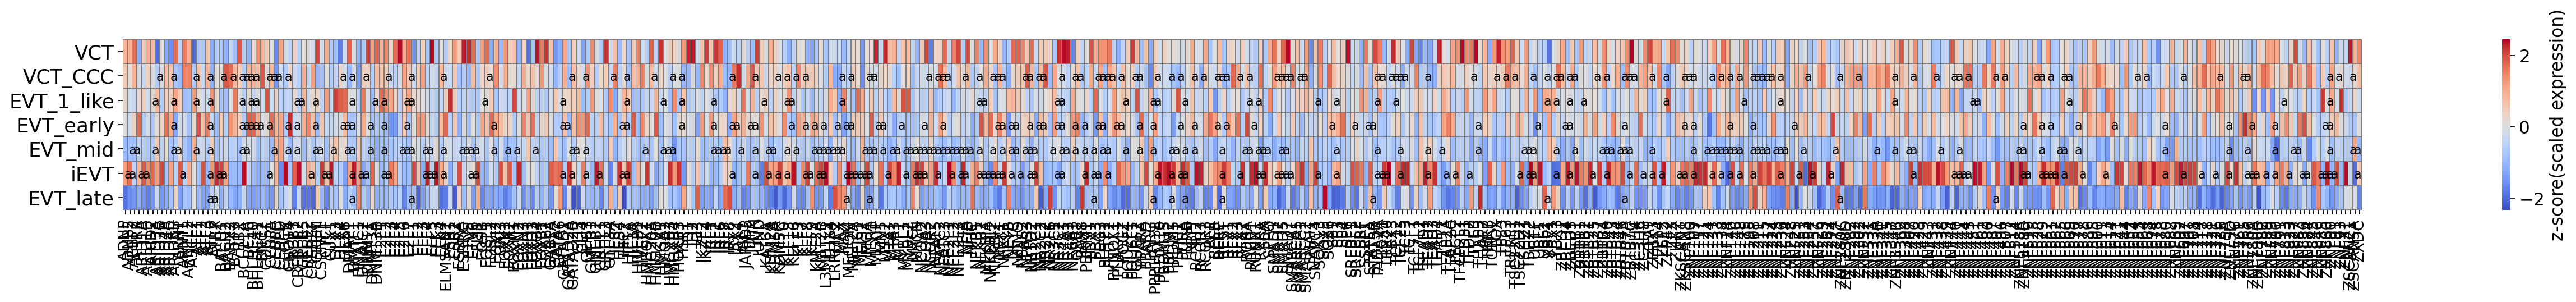

In [69]:
# playing a bit with the plotting here

# all MEs?

#curr_ME = 'ME_1_early_inv_column'

TFs2plot = sorted(list(set(DE_TFs_donor_P13_df_in_vivo.index) & set(df_avg_expr_zscores.index)))

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_all)):
    plt.annotate(coords_annotation_all[i][1], coords_annotation_all[i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


In [71]:
np.unique(df_TFs_evidence_per_ME['ME_1_early_inv_column']['VCT'])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [72]:
df_TFs_evidence_per_ME['ME_1_early_inv_column'].loc[sorted(MEs_TFs['ME_1_early_inv_column'])]

VCT VCT_CCC EVT_1_like EVT_early EVT_mid iEVT EVT_late
ADNP    NaN     NaN        NaN       NaN     NaN    a      NaN
ADNP2   NaN     NaN        NaN       NaN       a    a      NaN
AEBP2   NaN     NaN        NaN       NaN       a  NaN      NaN
ARID1A  NaN     NaN        NaN       NaN     NaN    a      NaN
ARID2   NaN     NaN        NaN       NaN     NaN    a      NaN
...     ...     ...        ...       ...     ...  ...      ...
ZNF84   NaN     NaN        NaN       NaN       a  NaN      NaN
ZNF85   NaN     NaN        NaN       NaN     NaN  NaN      NaN
ZNF90   NaN       a        NaN         a       a  NaN      NaN
ZNF93   NaN       a        NaN       NaN     NaN  NaN      NaN
ZXDC    NaN     NaN        NaN         a       a    a      NaN

[210 rows x 7 columns]

In [73]:
coords_annotation_per_ME = {}

for ME in MEs:
    print(ME)
    curr_df = df_TFs_evidence_per_ME[ME].loc[sorted(MEs_TFs[ME])]

    # coordinates where we want to add text annotation + annotation
    # [(float,float), str]
    coords_annotation_per_ME[ME] = []

    for TF in curr_df.index:
        #print(TF)
        x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
        curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
        #print(curr_coord_x)

        for ct in curr_df.columns:
            if str(curr_df.loc[TF,ct]) != 'nan':
                #print(TF, ct)
                y_shift = 0.7 # is different for different heatmaps (per ME)?
                curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
                coords_annotation_per_ME[ME].append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


ME_1_early_inv_column
ME_2_inv_front
ME_3_fusion
ME_4_artery_remodelling


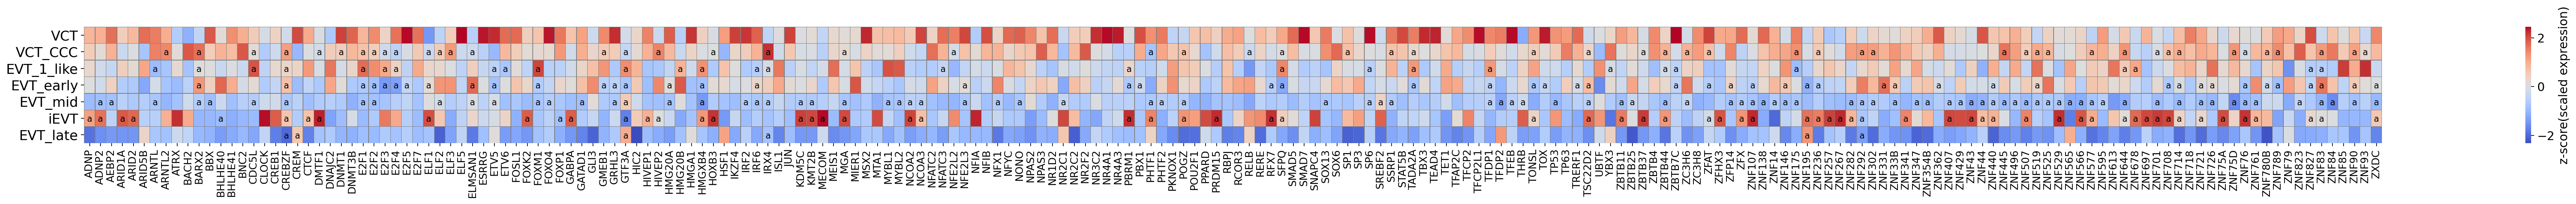

In [74]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_1_early_inv_column'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(list(set(TFs2plot) & set(df_avg_expr_zscores.index)))

plt.figure(figsize=(60,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/20220222_TFs_from_in_vivo_donor_P13_only_analysis_with_top_10%_limma_logFC_cutoff_expression_heatmap_zscores_in_vitro_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


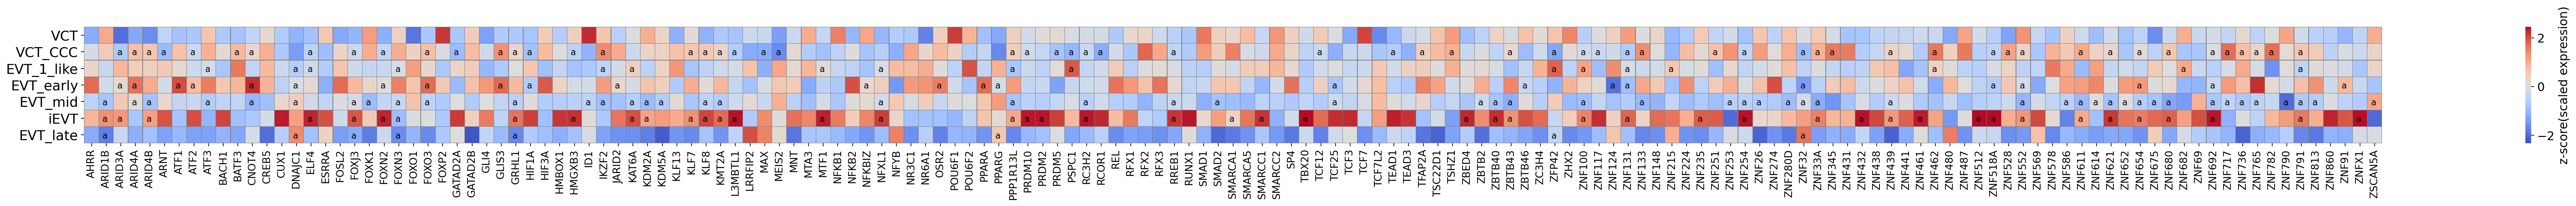

In [75]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_2_inv_front'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(list(set(TFs2plot) & set(df_avg_expr_zscores.index)))

plt.figure(figsize=(60,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/20220222_TFs_from_in_vivo_donor_P13_only_analysis_with_top_10%_limma_logFC_cutoff_expression_heatmap_zscores_in_vitro_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')
plt.show()


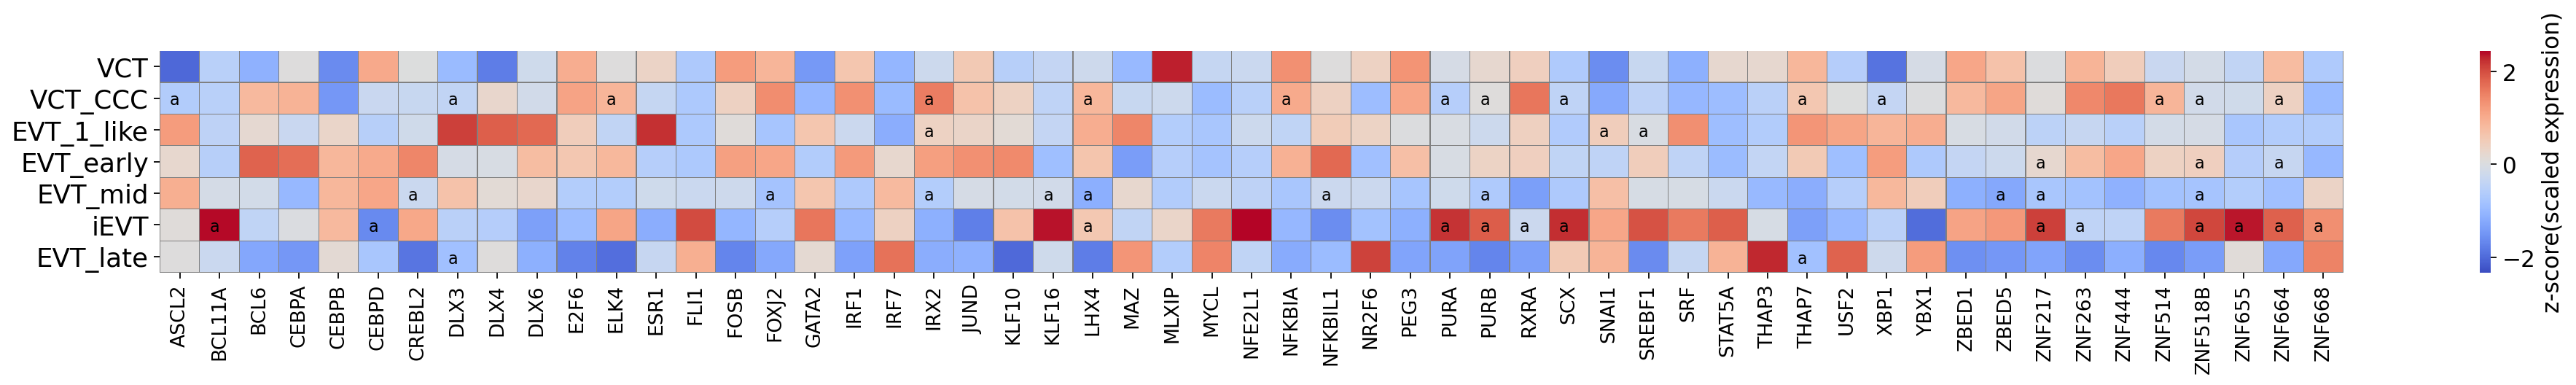

In [78]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_3_fusion'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(list(set(TFs2plot) & set(df_avg_expr_zscores.index)))

plt.figure(figsize=(30,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/20220222_TFs_from_in_vivo_donor_P13_only_analysis_with_top_10%_limma_logFC_cutoff_expression_heatmap_zscores_in_vitro_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


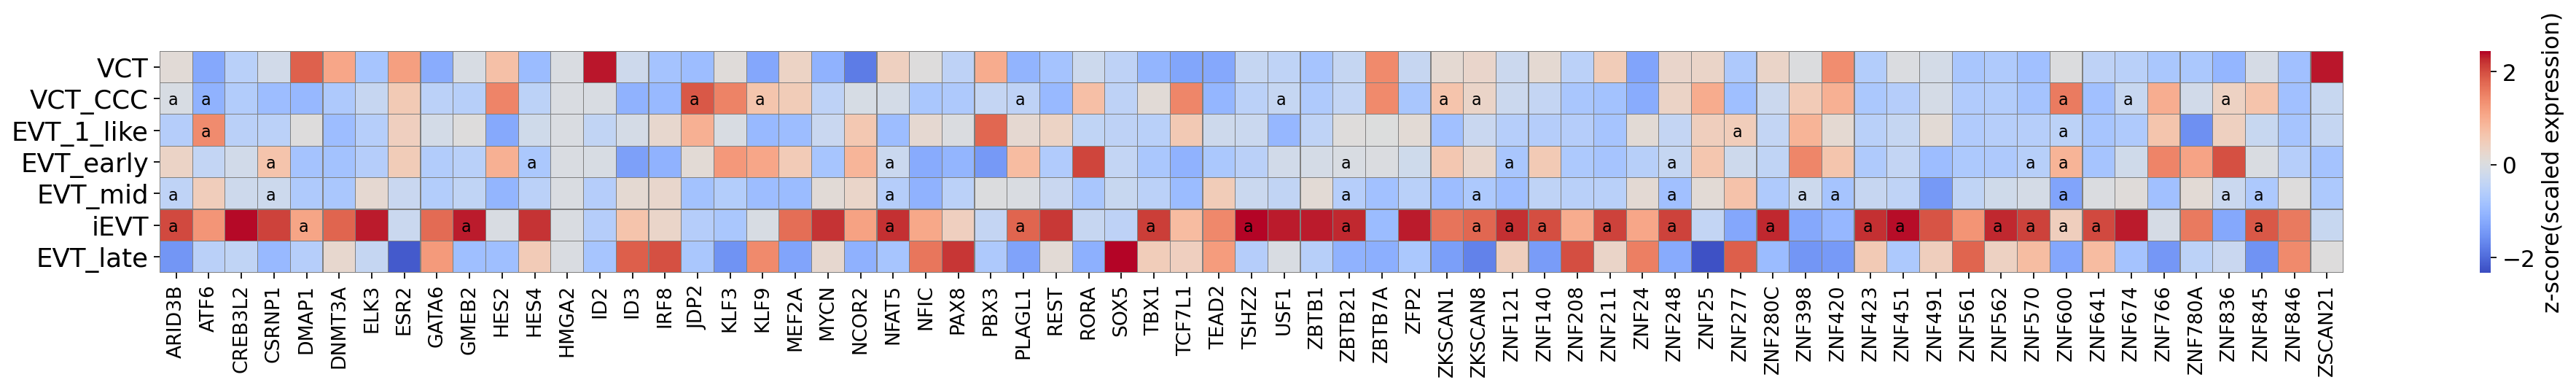

In [79]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_4_artery_remodelling'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(list(set(TFs2plot) & set(df_avg_expr_zscores.index)))

plt.figure(figsize=(30,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/20220222_TFs_from_in_vivo_donor_P13_only_analysis_with_top_10%_limma_logFC_cutoff_expression_heatmap_zscores_in_vitro_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


In [30]:
TFs_to_visualise_dfs['EVT_early_vs_VCT_CCC']

iEVT_vs_EVT EVT_vs_EVT_early EVT_early_vs_VCT_CCC VCT_CCC_vs_VCT
HIF1A           NaN              NaN                  NaN            NaN
ELF4            NaN              NaN                  NaN            NaN
TCF25           NaN              NaN                  NaN            NaN
FOXO3           NaN              NaN                  NaN            NaN
HEYL            NaN              NaN                  NaN            NaN
TSC22D3         NaN              NaN                  NaN            NaN
HOXB2           NaN              NaN                  NaN            NaN
ZNF397          NaN              NaN                  NaN            NaN
ZNF654          NaN              NaN                  NaN            NaN
OSR2            NaN              NaN                  NaN            NaN
ZNF350          NaN              NaN                  NaN            NaN
FOXN2           NaN              NaN                  NaN            NaN
ELF1            NaN              NaN                  NaN            NaN
ARID4A          NaN              NaN                  NaN            NaN
DNAJC1          NaN              NaN                  NaN            NaN
ZNF570          NaN              NaN                  NaN            NaN
PPARG           NaN              NaN                  NaN            NaN
CNOT4           NaN              NaN                  NaN            NaN
CSRNP1          NaN              NaN                  NaN            NaN
ZBTB21          NaN              NaN                  NaN            NaN
ARID3A          NaN              NaN                  NaN            NaN
TSC22D2         NaN              NaN                  NaN            NaN
THAP5           NaN              NaN                  NaN            NaN
EPAS1           NaN              NaN                  NaN            NaN
ZBTB38          NaN              NaN                  NaN            NaN
ATF1            NaN              NaN                  NaN            NaN
ATF2            NaN              NaN                  NaN            NaN
ZNF91           NaN              NaN                  NaN            NaN
NFKBIZ          NaN              NaN                  NaN            NaN
ATF4            NaN              NaN                  NaN            NaN
TBPL1           NaN              NaN                  NaN            NaN
ETV5            NaN              NaN                  NaN            NaN
PPARA           NaN              NaN                  NaN            NaN
SP100           NaN              NaN                  NaN            NaN
ZNF331          NaN              NaN                  NaN            NaN
TFEC            NaN              NaN                  NaN            NaN
ZBTB41          NaN              NaN                  NaN            NaN
ZBTB2           NaN              NaN                  NaN            NaN
HMG20B          NaN              NaN                  NaN            NaN
ZBTB46          NaN              NaN                  NaN            NaN
ATF6            NaN              NaN                  NaN            NaN
TGIF1           NaN              NaN                  NaN            NaN

In [31]:
for comparison_key_table in comparisons:
    for TF in TFs_to_visualise_dfs[comparison_key_table].index:
        for comparison_col in comparisons:
        
            if TF in DEGs[comparison_col].index:
                TFs_to_visualise_dfs[comparison_key_table].loc[TF,comparison_col] = DEGs[comparison_col].loc[TF,'AveExpr_cluster'] # take from limma
            else:
                TFs_to_visualise_dfs[comparison_key_table].loc[TF,comparison_col] = 0
    TFs_to_visualise_dfs[comparison_key_table] = TFs_to_visualise_dfs[comparison_key_table].astype(np.float64)

In [32]:
TFs_to_visualise_dfs['EVT_early_vs_VCT_CCC'].shape

(42, 4)

In [33]:
TFs_to_visualise_dfs['EVT_early_vs_VCT_CCC']

iEVT_vs_EVT  EVT_vs_EVT_early  EVT_early_vs_VCT_CCC  VCT_CCC_vs_VCT
HIF1A       0.909478          0.540866              0.453623        0.382697
ELF4        0.313053          0.140802              0.166705        0.126164
TCF25       1.280728          1.050943              1.016504        0.970321
FOXO3       0.307293          0.250211              0.454442        0.378623
HEYL        0.000000          0.000952              0.000374        0.000000
TSC22D3     0.080986          0.137663              0.184957        0.048750
HOXB2       0.028802          0.051540              0.077645        0.038396
ZNF397      0.211404          0.161813              0.154007        0.131468
ZNF654      0.135952          0.064333              0.118001        0.091301
OSR2        0.034698          0.043609              0.081898        0.070455
ZNF350      0.074712          0.048075              0.081590        0.062260
FOXN2       0.305624          0.154994              0.177495        0.155062
ELF1        0.805989          0.565331              0.586162        0.530898
ARID4A      0.150195          0.177512              0.227165        0.201249
DNAJC1      0.748937          0.624016              0.488876        0.244088
ZNF570      0.107283          0.047314              0.032458        0.025074
PPARG       0.727584          0.919670              0.698755        0.377249
CNOT4       0.191488          0.184451              0.259446        0.217675
CSRNP1      0.220009          0.121372              0.152917        0.095862
ZBTB21      0.237368          0.085384              0.117025        0.097528
ARID3A      2.121410          1.905843              1.850875        1.577202
TSC22D2     0.554287          0.283205              0.417455        0.384116
THAP5       0.077355          0.065283              0.101753        0.084529
EPAS1       2.108295          1.235981              1.209390        0.980475
ZBTB38      0.827898          0.363102              0.334663        0.274138
ATF1        0.121065          0.149158              0.299619        0.228398
ATF2        0.266765          0.136029              0.189107        0.141363
ZNF91       0.570912          0.278337              0.421469        0.334343
NFKBIZ      0.313859          0.199207              0.198886        0.126695
ATF4        0.868856          0.754871              1.045308        0.907427
TBPL1       0.126775          0.176395              0.161222        0.141144
ETV5        0.142167          0.145085              0.080220        0.061037
PPARA       0.079177          0.074961              0.093731        0.060174
SP100       0.535468          0.416255              0.458704        0.407266
ZNF331      0.045434          0.094653              0.311758        0.261136
TFEC        0.017301          0.003144              0.001140        0.000264
ZBTB41      0.265361          0.107689              0.132263        0.095741
ZBTB2       0.059935          0.040139              0.054103        0.044306
HMG20B      0.485415          0.682164              0.960587        0.634486
ZBTB46      0.020383          0.009945              0.008173        0.004927
ATF6        0.327446          0.299758              0.284457        0.253515
TGIF1       0.385369          0.665230              0.632961        0.495622

In [34]:
# visualising scaled gene expression
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202105_troph_organoids_exp_1_2/'
# final annotation in final_annot_v5
# normalised and log tr values in .X, all filtered genes and same in .raw
adata_organoids = sc.read(save_path + 'adata_scVI_analysed_no_cytokines_after_scVI_with_gene_filter_and_excluding_filter_mix_cluster.h5ad')


In [36]:
adata_organoids

AnnData object with n_obs × n_vars = 37480 × 23281
    obs: 'n_genes', 'time_point', 'activation_status', 'media', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'experiment', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'donor', 'prelim_annot_v2', 'S_score', 'G2M_score', 'phase', 'celltype_predictions_P13', 'probabilities_P13', 'celltype_predictions_Roser', 'probabilities_Roser', 'louvain', 'louvain_R', 'barcode_sample_copy', 'prelim_annot_v3', 'final_annot_v4', 'louvain_R_5', 'louvain_R_5,1', 'louvain_R_4', 'louvain_RR_4', 'louvain_final', 'louvain_RR_4_1', 'final_annot_v5', 'final_annot_v6', 'final_annot_v7', 'final_annot_v8'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids

In [37]:
np.unique(adata_organoids.obs['final_annot_v8'])

array(['EVT', 'EVT_early', 'SCT', 'VCT', 'VCT_CCC', 'VCT_fusing', 'iEVT'],
      dtype=object)

In [38]:
adata_organoids.X.shape

(37480, 23281)

In [39]:
df_expr = pd.DataFrame(adata_organoids.X,
                      columns = adata_organoids.var_names,
                      index = adata_organoids.obs_names)

In [40]:
# producing table of avr expression
df_avg_expr = pd.DataFrame(index = adata_organoids.var_names,
                           columns=['VCT_CCC','EVT_early', 'EVT', 'iEVT'])

In [41]:
# subset to only our TFs here
df_avg_expr = df_avg_expr.loc[TFs_to_visualise_union,:]

In [42]:
%%time

i = 0
for gene in df_avg_expr.index:
    if i%100 == 0:
        print(i)
    for ct in df_avg_expr.columns:
        curr_obs_names = list(adata_organoids[adata_organoids.obs['final_annot_v8'] == ct].obs_names)
        df_avg_expr.loc[gene,ct] = np.mean(df_expr.loc[curr_obs_names,gene])
    i += 1

0


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


100
200
300
CPU times: user 2min 27s, sys: 38.2 s, total: 3min 5s
Wall time: 3min 6s


In [43]:
# save to read in later
# already done
df_avg_expr.to_csv('./intermediate_files/20220116_df_avg_scaled_expr_TFs_union_in_vitro.csv')

In [44]:
# read in from file
df_avg_expr = pd.read_csv('./intermediate_files/20220116_df_avg_scaled_expr_TFs_union_in_vitro.csv', index_col=0)

In [62]:
# need to take per TF z-score
df_avg_expr_zscores = df_avg_expr.copy()

for TF in df_avg_expr_zscores.index:
    df_avg_expr_zscores.loc[TF,:] = scipy.stats.zscore(list(df_avg_expr.loc[TF,:]))

In [63]:
TFs_to_visualise_dfs_scaled = {}

for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs_scaled[comparison] = TFs_to_visualise_dfs[comparison]
    
    for TF in TFs_to_visualise_dfs_scaled[comparison].index:
        #print(TF)
        for comparison_col in TFs_to_visualise_dfs_scaled[comparison].columns:
            #print(comparison_col)
            # ignore if not enough cells are expressing it from limma tables
            if TF in DEGs[comparison].index:
                ct_in_df_avg_expr = comparison_col.split('_vs_')[0]
                TFs_to_visualise_dfs_scaled[comparison].loc[TF,comparison_col] = df_avg_expr_zscores.loc[TF,ct_in_df_avg_expr]
            else:
                TFs_to_visualise_dfs_scaled[comparison].loc[TF,comparison_col] = 0
                
                
    # also rename columns to just cell type labels
    # info about comparison will be in comparison key
    TFs_to_visualise_dfs_scaled[comparison].columns = [elem.split('_vs_')[0] for elem in TFs_to_visualise_dfs_scaled[comparison].columns]

    # sort TFs by alphabet
    TFs_to_visualise_dfs_scaled[comparison] = TFs_to_visualise_dfs_scaled[comparison].loc[list(sorted(TFs_to_visualise_dfs_scaled[comparison].index)),:]
    
    # additionally add the expression in VCT cluster as the origin
    #TFs_to_visualise_dfs_scaled[comparison]['VCT'] = df_avg_expr.loc[:,'VCT']
    
    
    TFs_to_visualise_dfs_scaled[comparison] = TFs_to_visualise_dfs_scaled[comparison].astype(np.float64)

iEVT_vs_EVT
EVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT


In [64]:
TFs_to_visualise_dfs_scaled['iEVT_vs_EVT']

iEVT       EVT  EVT_early   VCT_CCC
ADNP      1.242317 -1.510691  -0.128918  0.397293
ADNP2     1.576688 -1.171140  -0.376342 -0.029206
ARID1A    1.719821 -0.741973  -0.571376 -0.406473
ARID1B    1.402859 -1.295800  -0.470158  0.363099
ARID2     1.668921 -0.867034  -0.666878 -0.135009
ARID3A    1.328195  0.216627  -0.066814 -1.478008
ARID3B    1.667321 -0.970726  -0.215804 -0.480791
ARID4B    0.898883 -1.677155   0.584465  0.193806
ARX       1.636709 -0.013644  -0.855278 -0.767787
BCL11A    1.681091 -0.167335  -0.746801 -0.766955
CIC       1.719492 -0.746147  -0.406320 -0.567025
CREBZF    0.311563 -1.657253   0.318586  1.027104
CTCF      1.337875 -1.467185  -0.092026  0.221337
CXXC1     1.637732 -1.051097  -0.150213 -0.436422
DLX1      1.731165 -0.627320  -0.564225 -0.539619
DMAP1     1.707045 -0.422056  -0.439682 -0.845307
DMTF1     1.708482 -0.723787  -0.682621 -0.302074
E4F1      1.720519 -0.387798  -0.692375 -0.640346
ELF1      1.702882 -0.525642  -0.332743 -0.844497
ELF4      1.698753 -0.616726  -0.268528 -0.813499
FOXJ3     1.587327 -0.819830   0.123077 -0.890574
FOXK2     1.536072 -1.266195  -0.114739 -0.155137
FOXN2     1.713383 -0.691221  -0.332023 -0.690139
GABPA     1.617418 -1.109771  -0.145397 -0.362251
GCM1      1.262089  0.627240  -0.606345 -1.282984
GMEB2     1.730707 -0.554167  -0.536158 -0.640382
GRHL1     1.411131 -1.376456   0.220860 -0.255534
GRHL2     1.680851 -0.953206  -0.390338 -0.337307
HIVEP1    1.020285 -0.986174  -1.013524  0.979413
HIVEP2   -0.416418 -1.426815   0.707091  1.136142
HLF       1.731985 -0.588257  -0.579823 -0.563905
HMGXB3    1.723181 -0.677010  -0.411130 -0.635041
HMGXB4    1.489386 -1.274742  -0.365900  0.151256
HNF4G     1.730356 -0.510362  -0.634573 -0.585420
HOXA9     1.729848 -0.619770  -0.615753 -0.494325
HOXB3     1.675835 -0.971207  -0.358776 -0.345852
HOXB5     1.721163 -0.443732  -0.527398 -0.750034
HOXB8     1.695815 -0.233525  -0.714804 -0.747486
ID4       1.611673  0.028299  -0.651232 -0.988740
KAT6A     1.692252 -0.892992  -0.301040 -0.498221
KDM2A     1.135379 -1.605810   0.339229  0.131202
KDM5B     1.633989 -1.003721  -0.066129 -0.564139
KDM5C     1.673637 -0.976448  -0.313588 -0.383602
KLF7      1.223841 -1.558031   0.264334  0.069856
KLF8      1.597897 -1.068071  -0.552655  0.022830
KMT2A     1.406377 -1.393359   0.194202 -0.207220
KMT2B     1.635881 -1.071313  -0.190602 -0.373966
L3MBTL1   1.719167 -0.443063  -0.507786 -0.768318
LHX4      0.426465 -1.720533   0.545578  0.748491
MAFG      1.578478  0.095630  -0.615758 -1.058350
MAFK      1.639945 -1.066813  -0.222345 -0.350786
MECOM     1.728458 -0.480557  -0.661837 -0.586063
MEF2D     1.536012 -1.209361   0.086438 -0.413088
MGA       1.623540 -1.093292  -0.383972 -0.146276
MIER3     1.014342 -1.650693   0.170102  0.466249
MTA2      1.572743 -0.891745  -0.840194  0.159196
MTF1      1.694267 -0.315515  -0.490088 -0.888664
NCOA1     1.672931 -0.231642  -0.487207 -0.954082
NCOA2     1.709651 -0.831355  -0.428193 -0.450103
NCOA3     1.688235 -0.914027  -0.301317 -0.472891
NFAT5     1.713357 -0.773300  -0.580844 -0.359213
NFE2      1.643843 -0.083814  -0.587780 -0.972250
NFXL1     1.633450 -0.629445  -0.037447 -0.966559
PBRM1     1.732038 -0.572678  -0.583459 -0.575901
PBX4      1.719050 -0.373316  -0.674087 -0.671647
PHTF1     1.705941 -0.337827  -0.825072 -0.543042
PLAGL1    1.514179 -0.681383   0.253007 -1.085803
POGZ      1.254404 -1.504844  -0.130276  0.380716
POU2F3    0.059669 -1.502826   0.131409  1.311748
PPP1R13L  0.898961 -1.654845   0.667492  0.088391
PRDM10    1.723762 -0.713432  -0.573270 -0.437060
PRDM15    1.707797 -0.788871  -0.598923 -0.320004
PRDM2     1.724791 -0.723621  -0.488387 -0.512782
PRDM4     1.697905 -0.829182  -0.272749 -0.595973
PRDM6     1.731867 -0.564160  -0.566697 -0.601010
PURA      1.706587 -0.560337  -0.331632 -0.814619
PURB      1.584771 -1.176810  -0.102982 -0.304980
RBAK      1.426306 -1.382030  -0.187460  0.143184
RC3H2     1.722670 -0.741363  -0.465081 -0.516226
RFX7      1.70

In [65]:
TFs_to_visualise_dfs_scaled['EVT_early_vs_VCT_CCC']

iEVT       EVT  EVT_early   VCT_CCC
ARID3A   1.328195  0.216627  -0.066814 -1.478008
ARID4A  -1.363597 -0.404442   1.339019  0.429019
ATF1    -1.122929 -0.721034   1.431413  0.412551
ATF2     1.591777 -0.901919   0.110504 -0.800362
ATF4    -0.243443 -1.342005   1.457154  0.128293
ATF6     1.353761  0.316953  -0.256035 -1.414679
CNOT4   -0.740794 -0.980191   1.570970  0.150014
CSRNP1   1.559637 -0.563170   0.115729 -1.112196
DNAJC1   1.188409  0.521059  -0.200884 -1.508584
ELF1     1.702882 -0.525642  -0.332743 -0.844497
ELF4     1.698753 -0.616726  -0.268528 -0.813499
EPAS1    1.685222 -0.343095  -0.404925 -0.937202
ETV5     0.943501  1.022082  -0.724534 -1.241050
FOXN2    1.713383 -0.691221  -0.332023 -0.690139
FOXO3   -0.526567 -1.271498   1.393755  0.404311
HEYL    -0.859952  1.581731   0.138172 -0.859952
HIF1A    1.664739 -0.151781  -0.581716 -0.931243
HMG20B  -1.193919 -0.049437   1.570136 -0.326780
HOXB2   -1.105692  0.133193   1.555555 -0.583056
NFKBIZ   1.554750 -0.155995  -0.160788 -1.237968
OSR2    -1.195366 -0.732854   1.259921  0.668300
PPARA    0.185210 -0.168958   1.394910 -1.411162
PPARG    0.240151  1.226461   0.092117 -1.558729
SP100    1.599667 -0.753364   0.084486 -0.930790
TBPL1   -1.300282  1.321501   0.519803 -0.541022
TCF25    1.681764 -0.239846  -0.527854 -0.914064
TFEC     1.707574 -0.298063  -0.673208 -0.736302
TGIF1   -1.424351  1.075990   0.787692 -0.439330
THAP5   -0.369223 -1.283459   1.478541  0.174141
TSC22D2  1.490203 -1.305013   0.079290 -0.264480
TSC22D3 -0.613430  0.472225   1.372666 -1.231461
ZBTB2    1.318988 -1.211527   0.573445 -0.680906
ZBTB21   1.701694 -0.808263  -0.285720 -0.607712
ZBTB38   1.713576 -0.393762  -0.522700 -0.797115
ZBTB41   1.699019 -0.628460  -0.265721 -0.804838
ZBTB46   1.648873 -0.124465  -0.534370 -0.990039
ZNF331  -1.196024 -0.752787   1.202339  0.746472
ZNF350   0.631861 -1.455636   1.167723 -0.343948
ZNF397   1.600904 -0.097969  -0.365395 -1.137540
ZNF570   1.677895 -0.176544  -0.635625 -0.865726
ZNF654   1.237398 -1.403666   0.575447 -0.409178
ZNF91    1.536252 -1.113191   0.182961 -0.606022

In [66]:
# subset to only invading ones

TFs_to_visualise_dfs_scaled_only_inv = {}

for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs_scaled_only_inv[comparison] = TFs_to_visualise_dfs_scaled[comparison].loc[:,['VCT_CCC','EVT_early',
                                                                                                      'EVT','iEVT']]

iEVT_vs_EVT
EVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT


In [67]:
TFs_to_visualise_dfs_scaled_only_inv['EVT_early_vs_VCT_CCC']

VCT_CCC  EVT_early       EVT      iEVT
ARID3A  -1.478008  -0.066814  0.216627  1.328195
ARID4A   0.429019   1.339019 -0.404442 -1.363597
ATF1     0.412551   1.431413 -0.721034 -1.122929
ATF2    -0.800362   0.110504 -0.901919  1.591777
ATF4     0.128293   1.457154 -1.342005 -0.243443
ATF6    -1.414679  -0.256035  0.316953  1.353761
CNOT4    0.150014   1.570970 -0.980191 -0.740794
CSRNP1  -1.112196   0.115729 -0.563170  1.559637
DNAJC1  -1.508584  -0.200884  0.521059  1.188409
ELF1    -0.844497  -0.332743 -0.525642  1.702882
ELF4    -0.813499  -0.268528 -0.616726  1.698753
EPAS1   -0.937202  -0.404925 -0.343095  1.685222
ETV5    -1.241050  -0.724534  1.022082  0.943501
FOXN2   -0.690139  -0.332023 -0.691221  1.713383
FOXO3    0.404311   1.393755 -1.271498 -0.526567
HEYL    -0.859952   0.138172  1.581731 -0.859952
HIF1A   -0.931243  -0.581716 -0.151781  1.664739
HMG20B  -0.326780   1.570136 -0.049437 -1.193919
HOXB2   -0.583056   1.555555  0.133193 -1.105692
NFKBIZ  -1.237968  -0.160788 -0.155995  1.554750
OSR2     0.668300   1.259921 -0.732854 -1.195366
PPARA   -1.411162   1.394910 -0.168958  0.185210
PPARG   -1.558729   0.092117  1.226461  0.240151
SP100   -0.930790   0.084486 -0.753364  1.599667
TBPL1   -0.541022   0.519803  1.321501 -1.300282
TCF25   -0.914064  -0.527854 -0.239846  1.681764
TFEC    -0.736302  -0.673208 -0.298063  1.707574
TGIF1   -0.439330   0.787692  1.075990 -1.424351
THAP5    0.174141   1.478541 -1.283459 -0.369223
TSC22D2 -0.264480   0.079290 -1.305013  1.490203
TSC22D3 -1.231461   1.372666  0.472225 -0.613430
ZBTB2   -0.680906   0.573445 -1.211527  1.318988
ZBTB21  -0.607712  -0.285720 -0.808263  1.701694
ZBTB38  -0.797115  -0.522700 -0.393762  1.713576
ZBTB41  -0.804838  -0.265721 -0.628460  1.699019
ZBTB46  -0.990039  -0.534370 -0.124465  1.648873
ZNF331   0.746472   1.202339 -0.752787 -1.196024
ZNF350  -0.343948   1.167723 -1.455636  0.631861
ZNF397  -1.137540  -0.365395 -0.097969  1.600904
ZNF570  -0.865726  -0.635625 -0.176544  1.677895
ZNF654  -0.409178   0.575447 -1.403666  1.237398
ZNF91   -0.606022   0.182961 -1.113191  1.536252

In [68]:
def plot_heatmap(data_table, abs_color_lim = None):
    
    dim_y = int(len(data_table) / 2.5)
    
    dim_x = int(data_table.shape[1] / 2)
    
    if abs_color_lim == None:
        min_color_lim = -max(abs(np.min(data_table.values)), abs(np.max(data_table.values)))
        max_color_lim = max(abs(np.min(data_table.values)), abs(np.max(data_table.values)))
    else:
        min_color_lim = -abs_color_lim
        max_color_lim = abs_color_lim
        
    plt.figure(figsize=(dim_x,dim_y))
    sns.heatmap(data_table, cmap='coolwarm', 
                vmin = min_color_lim,
                vmax = max_color_lim,
                 linewidths=0.1, linecolor='grey'
               )

In [73]:
df_avg_expr.loc['ZNF292']

VCT_CCC      0.392139
EVT_early    0.435788
EVT         -0.565188
iEVT        -0.532032
Name: ZNF292, dtype: float64

In [ ]:
df_avg_expr.loc['ZNF292']

In [71]:
DEGs['iEVT_vs_EVT'].loc['ZNF292']

logFC                  0.094982
P.Value                0.011480
adj.P.Val              0.035986
AveExpr_cluster        0.421510
AveExpr_rest           0.396075
percentExpr_cluster    0.531646
percentExpr_rest       0.555917
Name: ZNF292, dtype: float64

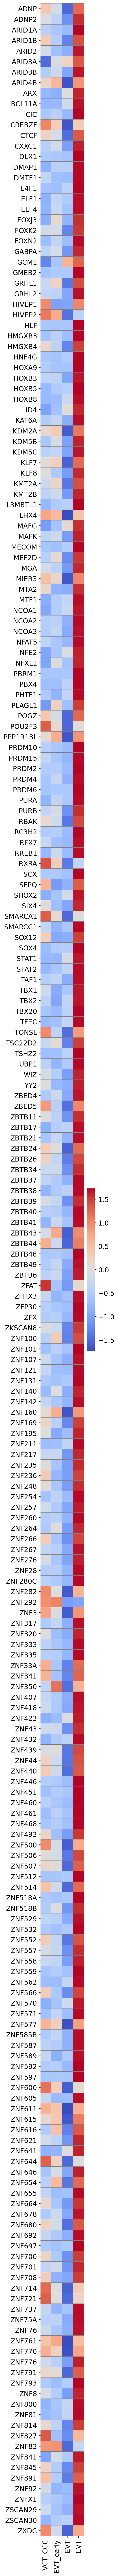

In [69]:
plot_heatmap(TFs_to_visualise_dfs_scaled_only_inv['iEVT_vs_EVT'])

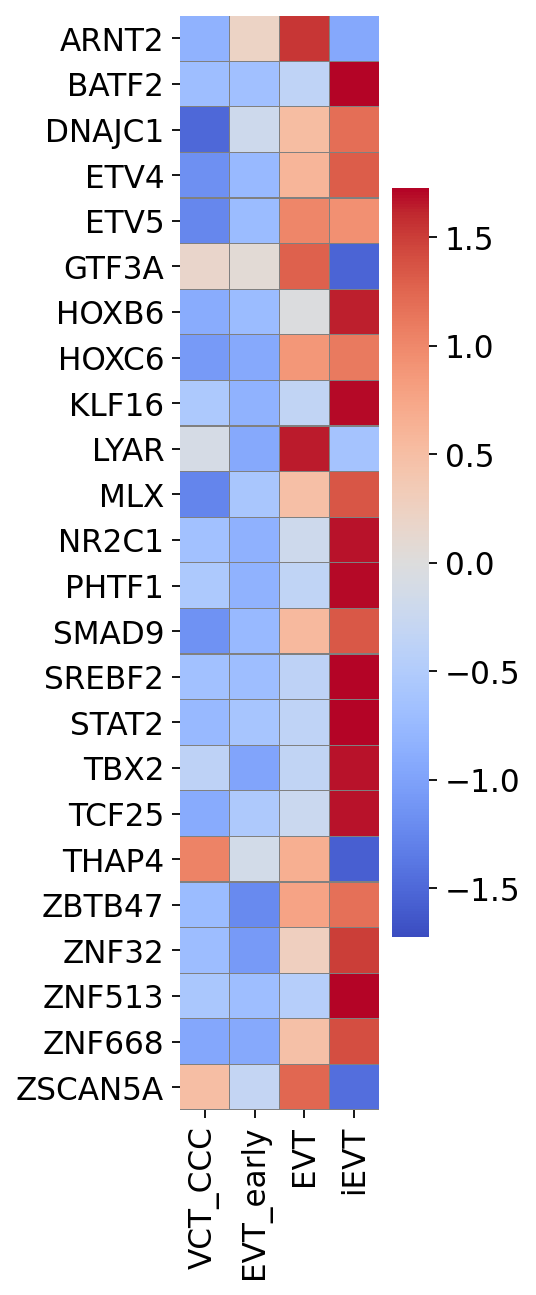

In [92]:
plot_heatmap(TFs_to_visualise_dfs_scaled_only_inv['EVT_vs_EVT_early'])

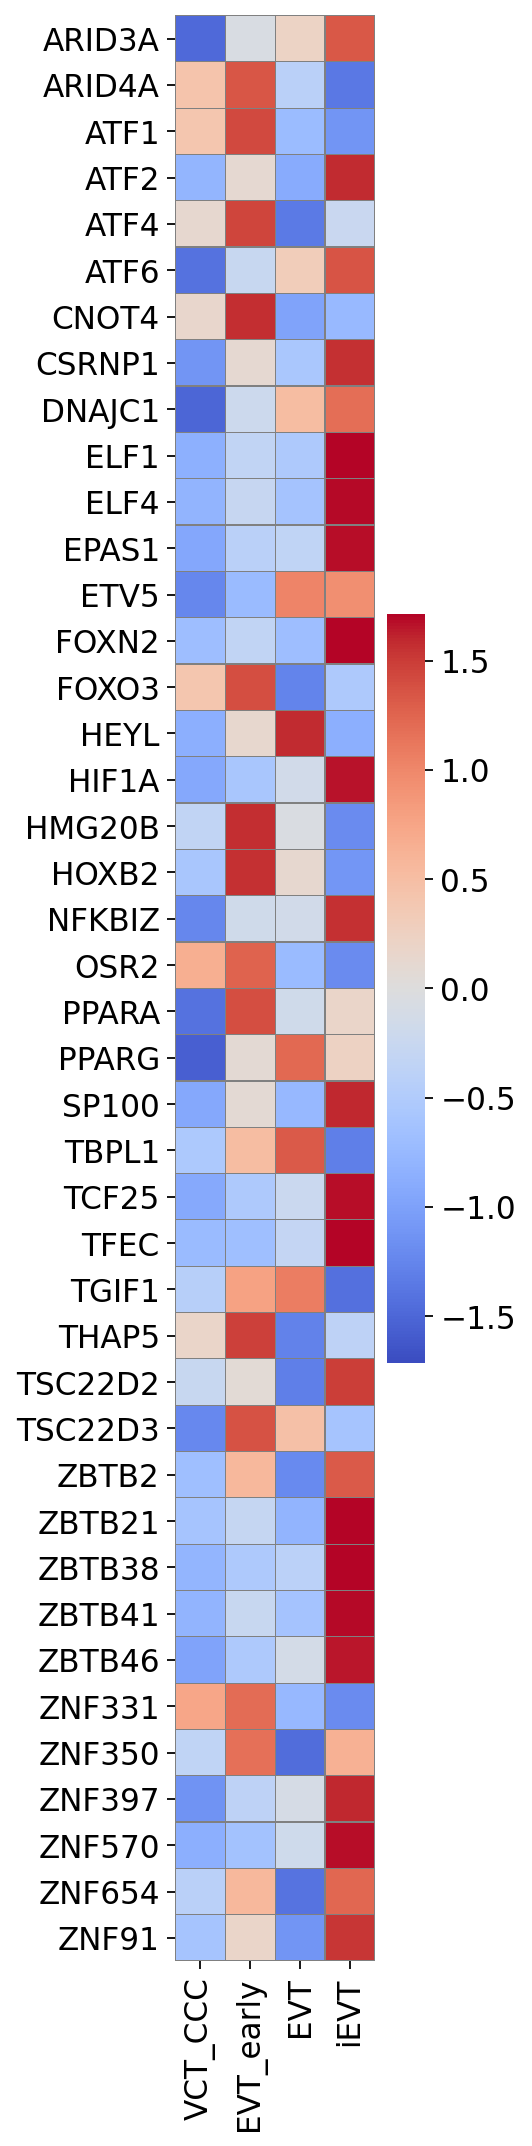

In [94]:
plot_heatmap(TFs_to_visualise_dfs_scaled_only_inv['EVT_early_vs_VCT_CCC'])

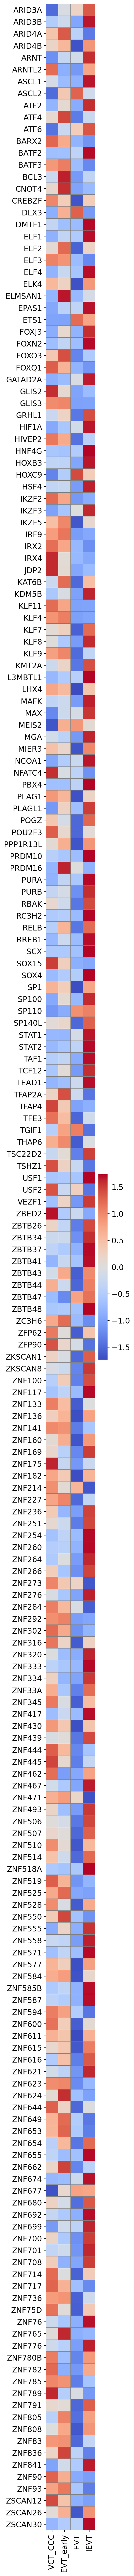

In [95]:
plot_heatmap(TFs_to_visualise_dfs_scaled_only_inv['VCT_CCC_vs_VCT'])

iEVT_vs_EVT
EVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT


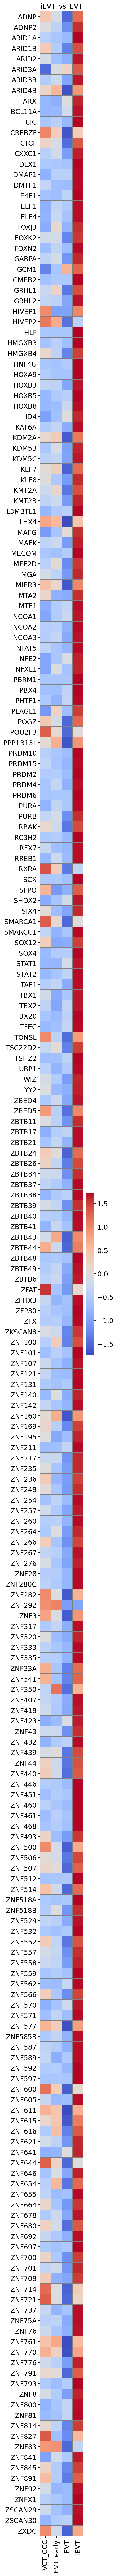

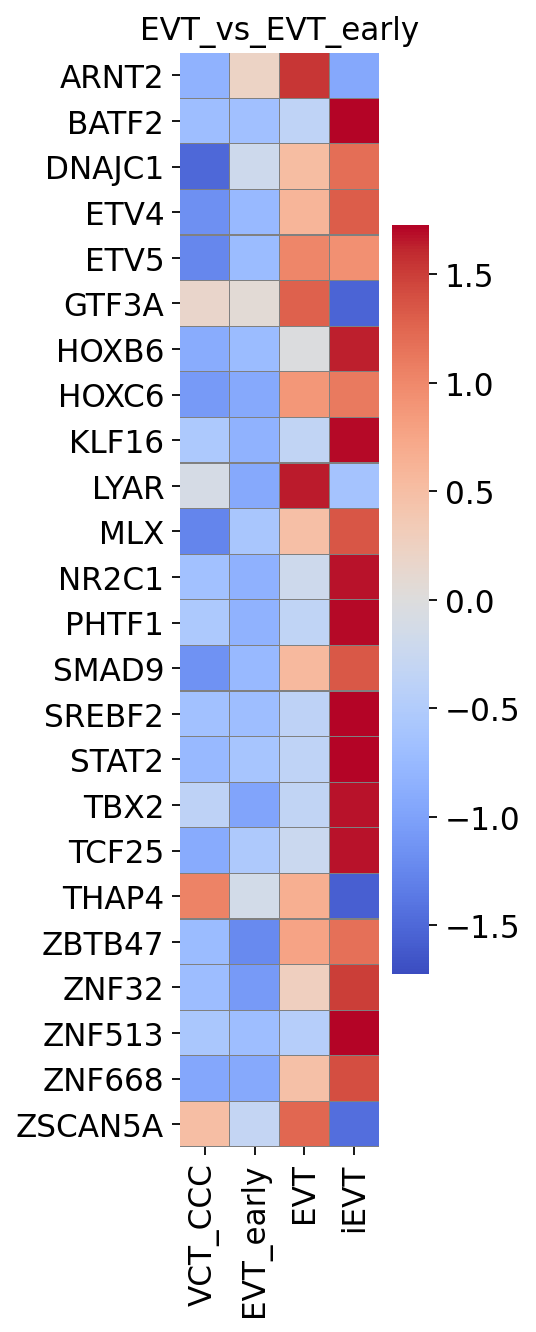

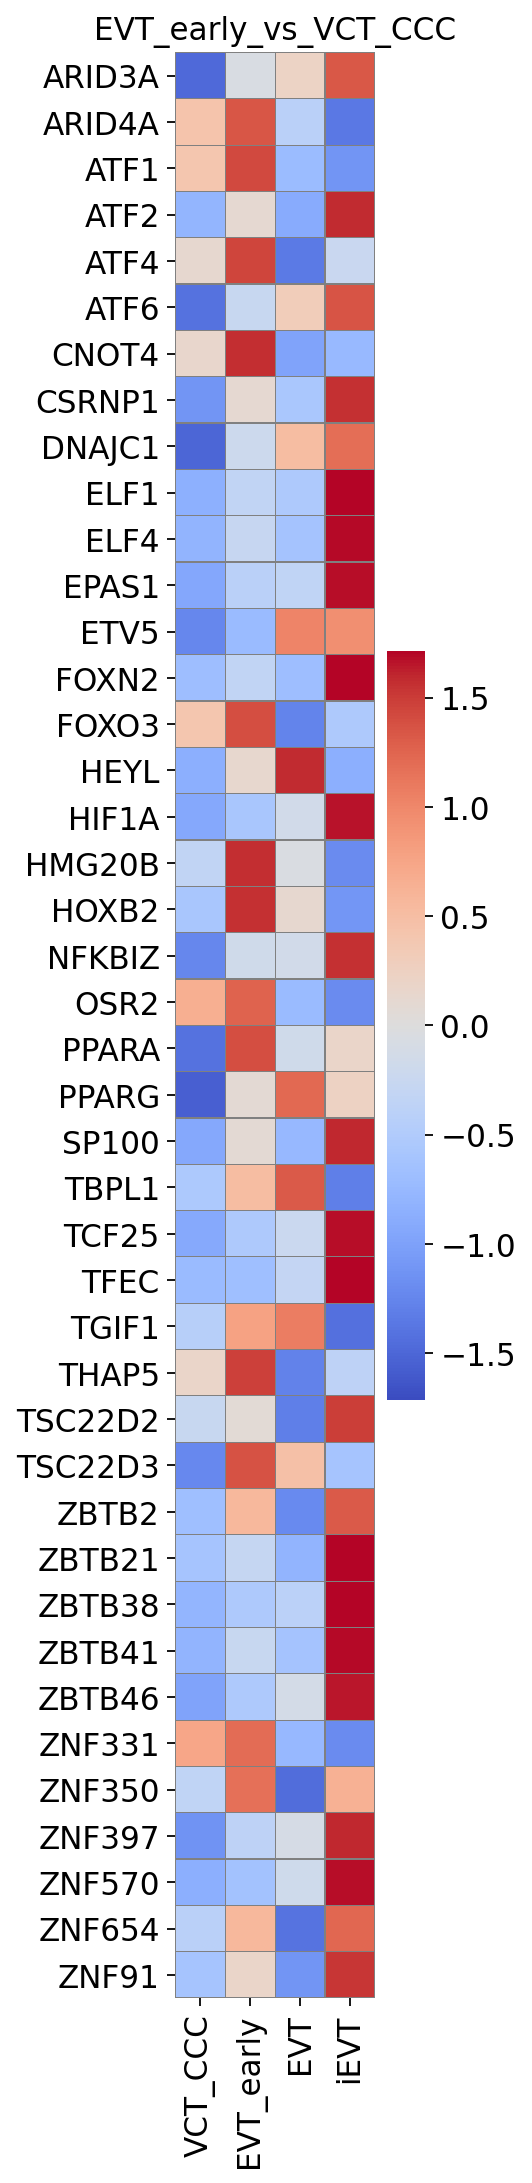

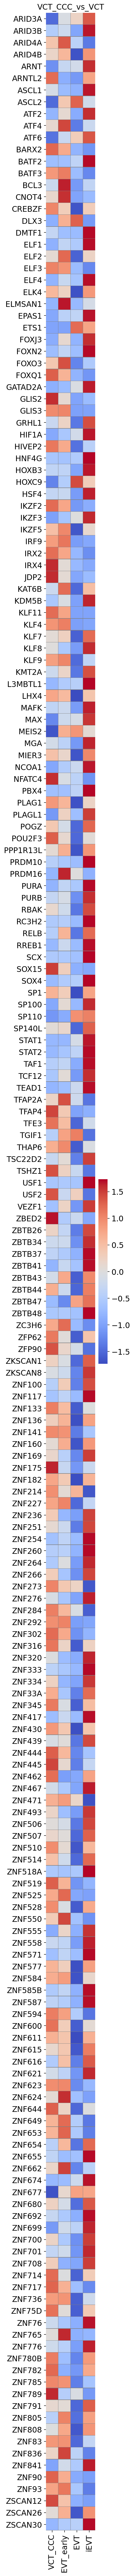

In [96]:
for comparison in comparisons:
    print(comparison)
    
    plot_heatmap(TFs_to_visualise_dfs_scaled_only_inv[comparison], 
                 #abs_color_lim=abs_limit
                )
    
    plt.title(comparison)
    plt.savefig('./figures/20220116_TFs_plot_DE_limma_and_DA_DoRothEA_' + comparison + '_comparison.pdf',
               bbox_inches='tight')

In [ ]:
# old code below

In [94]:
# seeing how the TFs here align with those in vivo (acc to Cellphone-like DE analysis)
TFs_to_visualise_dfs_scaled_in_vivo = {}

comparisons_in_vivo = ['GC_vs_iEVT','eEVT_vs_EVT_3','iEVT_vs_EVT_3',
                        'EVT_3_vs_EVT_2','EVT_2_vs_EVT_1','EVT_1_vs_VCT_CCC',
                        'VCT_CCC_vs_VCT']

for comparison in comparisons_in_vivo:
    print(comparison)
    TFs_to_visualise_dfs_scaled_in_vivo[comparison] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/TF_activities/intermediate_files/20211013_TFs_DE_limma_and_DA_DoRothEA_' + comparison + '_comparison.csv', 
                                                                   index_col=0)

GC_vs_iEVT
eEVT_vs_EVT_3
iEVT_vs_EVT_3
EVT_3_vs_EVT_2
EVT_2_vs_EVT_1
EVT_1_vs_VCT_CCC
VCT_CCC_vs_VCT


In [95]:
# so pre-GC are not really GC I guess... ?

for comparison_in_vitro in comparisons:
    print('in vitro comparison', comparison_in_vitro)
    
    for comparison_in_vivo in comparisons_in_vivo:
        print('common TFs (DE and DA) between current in vitro comparison', comparison_in_vitro, ' and', comparison_in_vivo, 'in vivo comparison',
              len(set(TFs_to_visualise_dfs_scaled_in_vivo[comparison_in_vivo].index) & set(TFs_to_visualise_dfs_scaled[comparison_in_vitro].index)))

in vitro comparison EVT_late_vs_EVT_mid
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and GC_vs_iEVT in vivo comparison 1
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and eEVT_vs_EVT_3 in vivo comparison 0
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and iEVT_vs_EVT_3 in vivo comparison 0
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and EVT_3_vs_EVT_2 in vivo comparison 2
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and EVT_2_vs_EVT_1 in vivo comparison 3
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and EVT_1_vs_VCT_CCC in vivo comparison 3
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_EVT_mid  and VCT_CCC_vs_VCT in vivo comparison 4
in vitro comparison iEVT_vs_EVT_late
common TFs (DE and DA) between current in vitro comparison iEVT_vs_EVT_late  and GC_vs_

In [70]:
abs_max = []
abs_min = []

for comparison in comparisons:
    print(comparison)
    abs_max.append(abs(np.max(TFs_to_visualise_dfs_scaled[comparison].values)))
    abs_min.append(abs(np.min(TFs_to_visualise_dfs_scaled[comparison].values)))
    
abs_limit = np.max(abs_max + abs_min)

EVT_late_vs_iEVT
iEVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT
SCT_vs_VCT_fusing
VCT_fusing_vs_VCT


In [71]:
abs_max

[0.8636192083358765,
 0.7009628415107727,
 1.274427890777588,
 1.2862781286239624,
 0.6230957508087158,
 1.5177668333053589]

In [72]:
abs_min

[0.42874276638031006,
 0.42874276638031006,
 0.6659104824066162,
 0.9337814450263977,
 1.050844669342041,
 0.6659104824066162]

In [73]:
abs_limit

1.5177668333053589

EVT_late_vs_iEVT
iEVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT


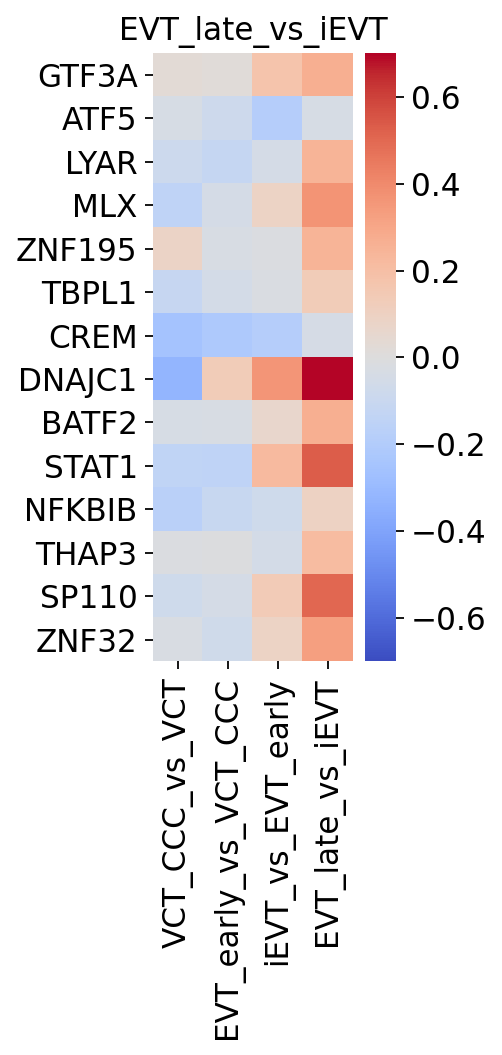

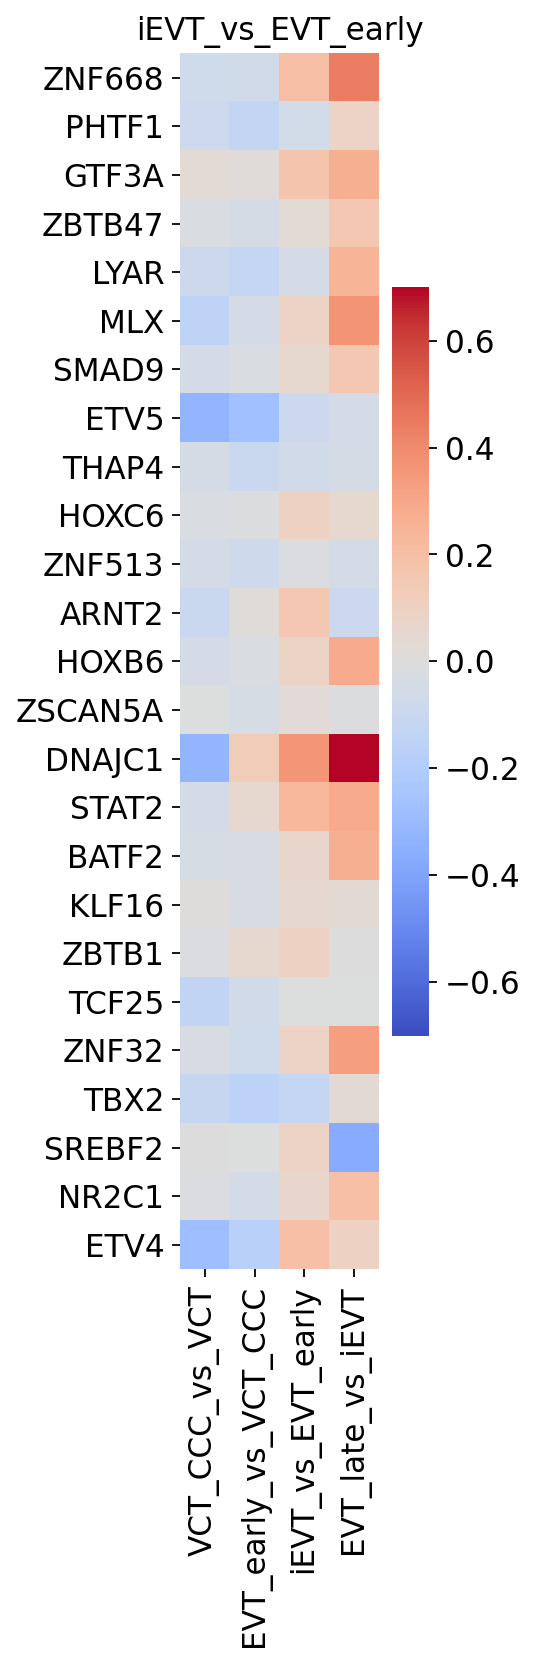

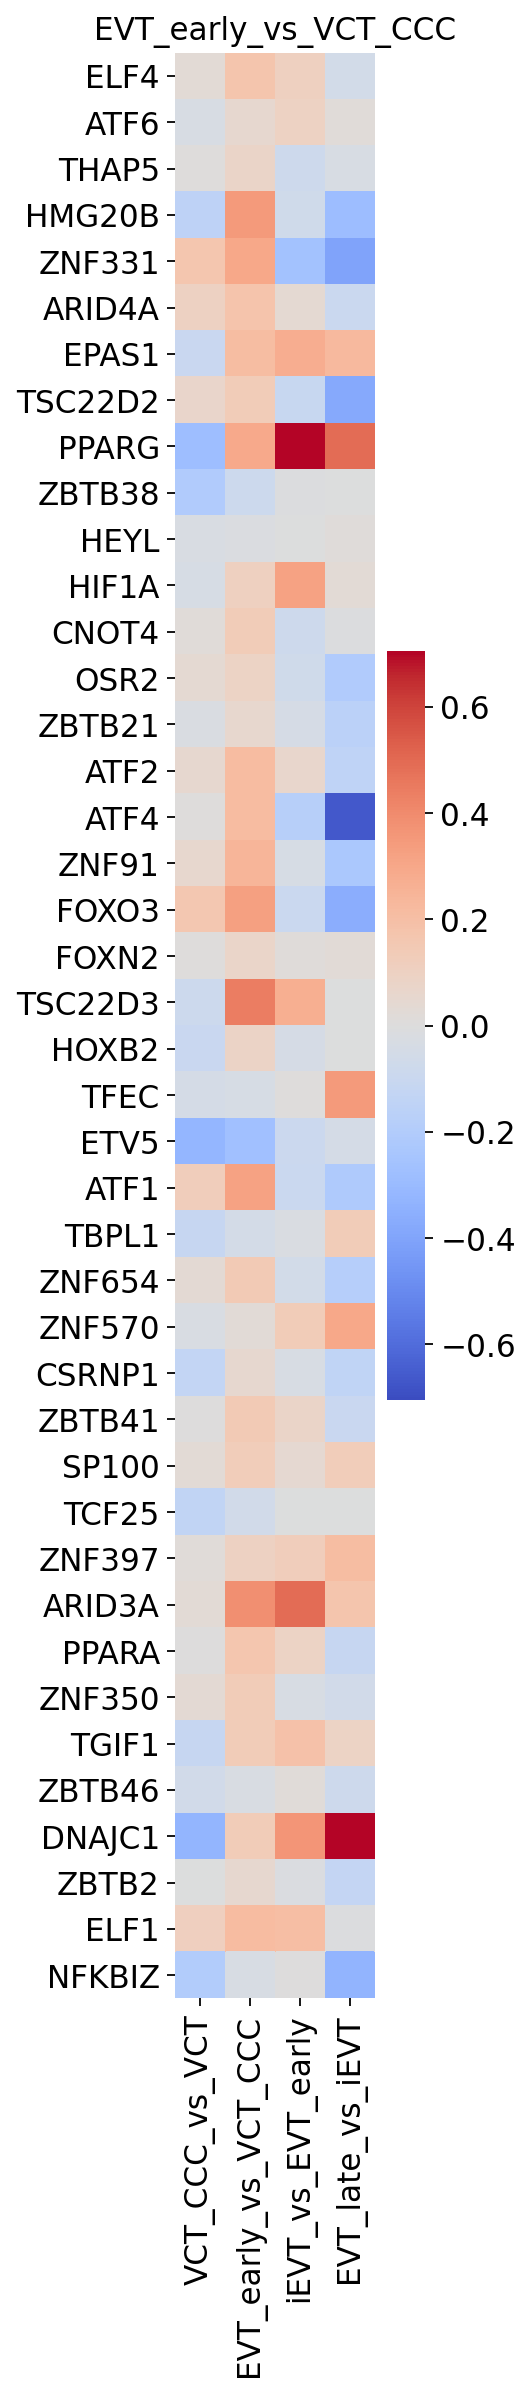

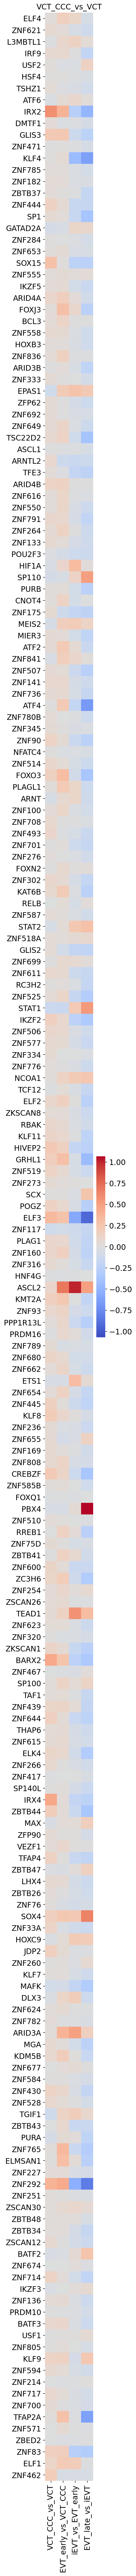

In [85]:
# saving some plots to have a look

order = [#'SCT_vs_VCT_fusing',
         #'VCT_fusing_vs_VCT',
         'VCT_CCC_vs_VCT',
         'EVT_early_vs_VCT_CCC',
         'iEVT_vs_EVT_early',
         'EVT_late_vs_iEVT'
        ]

for comparison in comparisons:
    
    if comparison in ['VCT_CCC_vs_VCT',
         'EVT_early_vs_VCT_CCC',
         'iEVT_vs_EVT_early',
         'EVT_late_vs_iEVT']:
        print(comparison)

        plot_heatmap(TFs_to_visualise_dfs_scaled_invasion[comparison].loc[:,order], 
                     #abs_color_lim=abs_limit
                    )
        plt.title(comparison)
        plt.savefig('./figures/20211015_TFs_plot_DE_limma_and_DA_DoRothEA_' + comparison + '_comparison.pdf',
                   bbox_inches='tight')

In [78]:
TFs_to_visualise_dfs_scaled['EVT_late_vs_iEVT'].index

Index(['GTF3A', 'ATF5', 'LYAR', 'MLX', 'ZNF195', 'TBPL1', 'CREM', 'DNAJC1',
       'BATF2', 'STAT1', 'NFKBIB', 'THAP3', 'SP110', 'ZNF32'],
      dtype='object')

In [79]:
# what about the TFs unique to each comparison/ cell state?

TFs_to_visualise_dfs_scaled_unique = {}

for comparison in comparisons:
    print(comparison) 
    
    TFs_others = []
    for comparison_ in comparisons:
        if comparison_ != comparison:
            TFs_others.append(TFs_to_visualise_dfs_scaled[comparison_].index)
    TFs_others = [item for sublist in TFs_others for item in sublist]
    TFs_others = list(set(TFs_others))
    
    curr_unique_TFs = [TF for TF in TFs_to_visualise_dfs_scaled[comparison].index if TF not in TFs_others]
    list(set(TFs_to_visualise_dfs_scaled[comparison].index) - set(TFs_to_visualise_union))
    
    TFs_to_visualise_dfs_scaled_unique[comparison] = TFs_to_visualise_dfs_scaled[comparison].loc[curr_unique_TFs,:]
    
    print(len(TFs_to_visualise_dfs_scaled_unique[comparison]), 'unique TFs')

EVT_late_vs_iEVT
5 unique TFs
iEVT_vs_EVT_early
15 unique TFs
EVT_early_vs_VCT_CCC
19 unique TFs
VCT_CCC_vs_VCT
173 unique TFs
SCT_vs_VCT_fusing
8 unique TFs
VCT_fusing_vs_VCT
18 unique TFs


In [80]:
abs_max = []
abs_min = []

for comparison in comparisons:
    print(comparison)
    abs_max.append(abs(np.max(TFs_to_visualise_dfs_scaled_unique[comparison].values)))
    abs_min.append(abs(np.min(TFs_to_visualise_dfs_scaled_unique[comparison].values)))
    
abs_limit = np.max(abs_max + abs_min)

EVT_late_vs_iEVT
iEVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT
SCT_vs_VCT_fusing
VCT_fusing_vs_VCT


In [81]:
abs_limit

1.5177668333053589

EVT_late_vs_iEVT
iEVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT
SCT_vs_VCT_fusing
VCT_fusing_vs_VCT


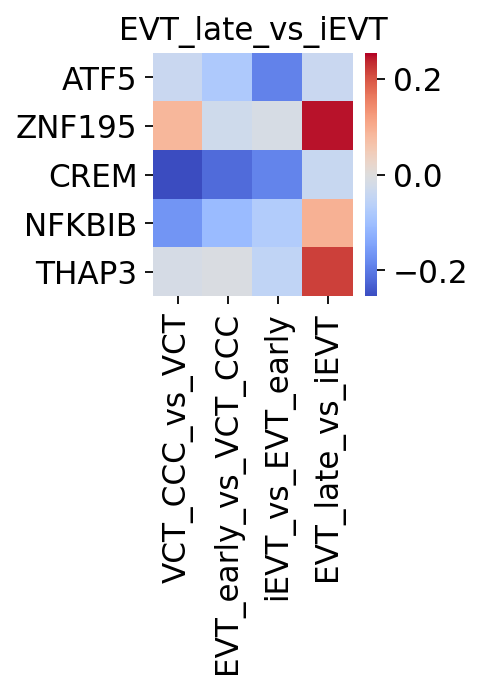

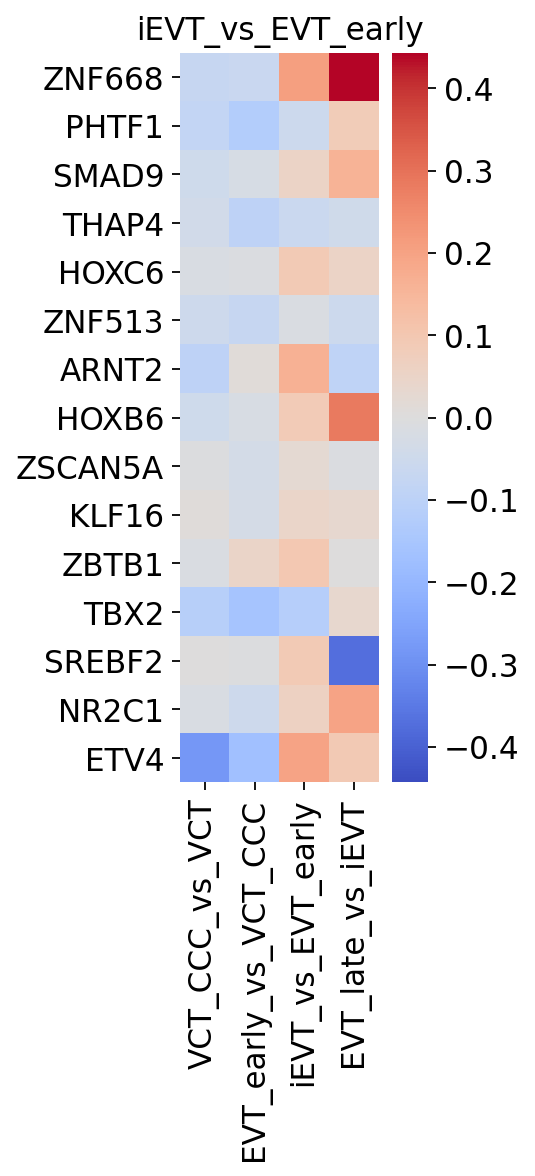

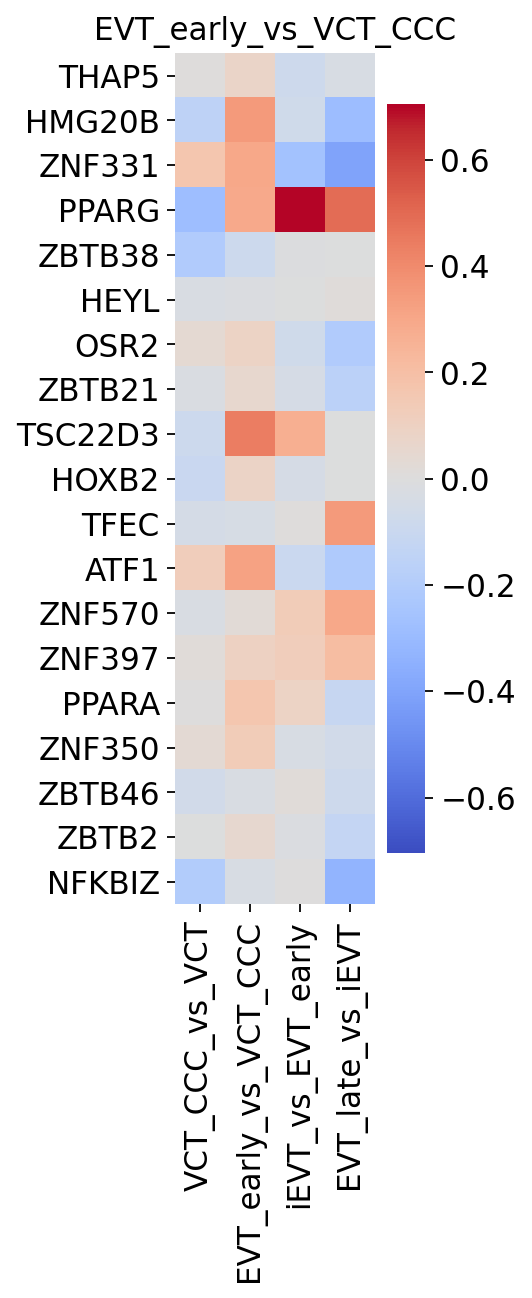

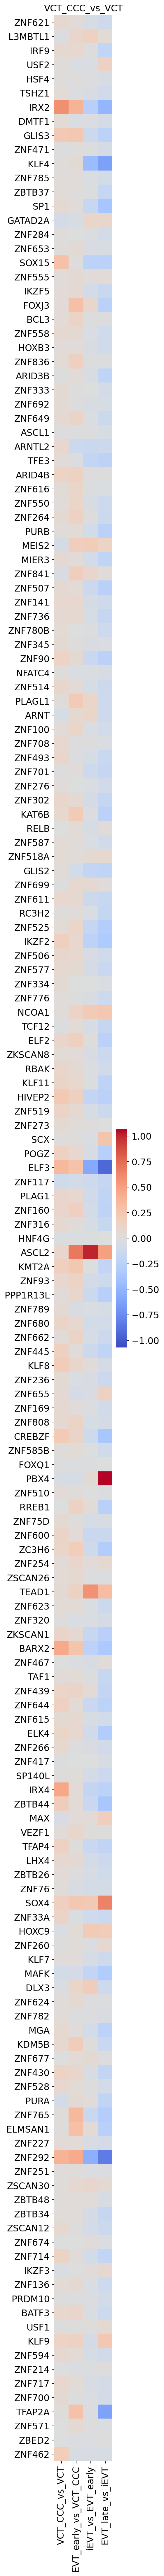

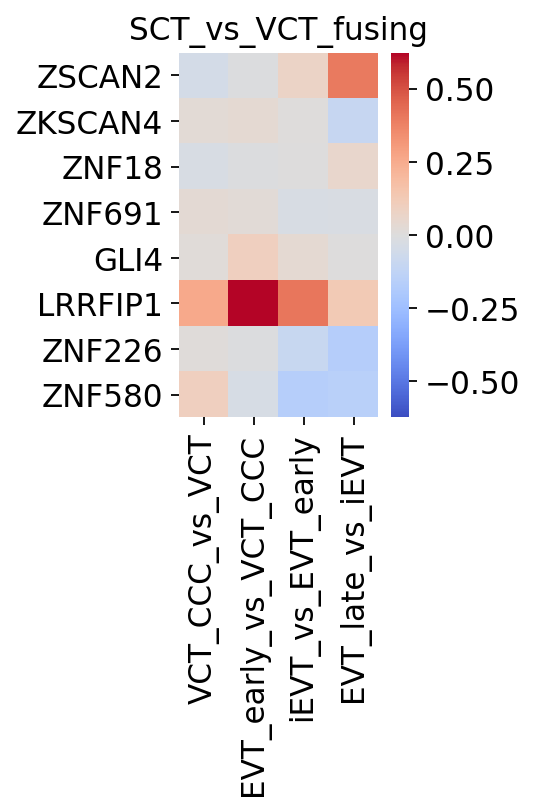

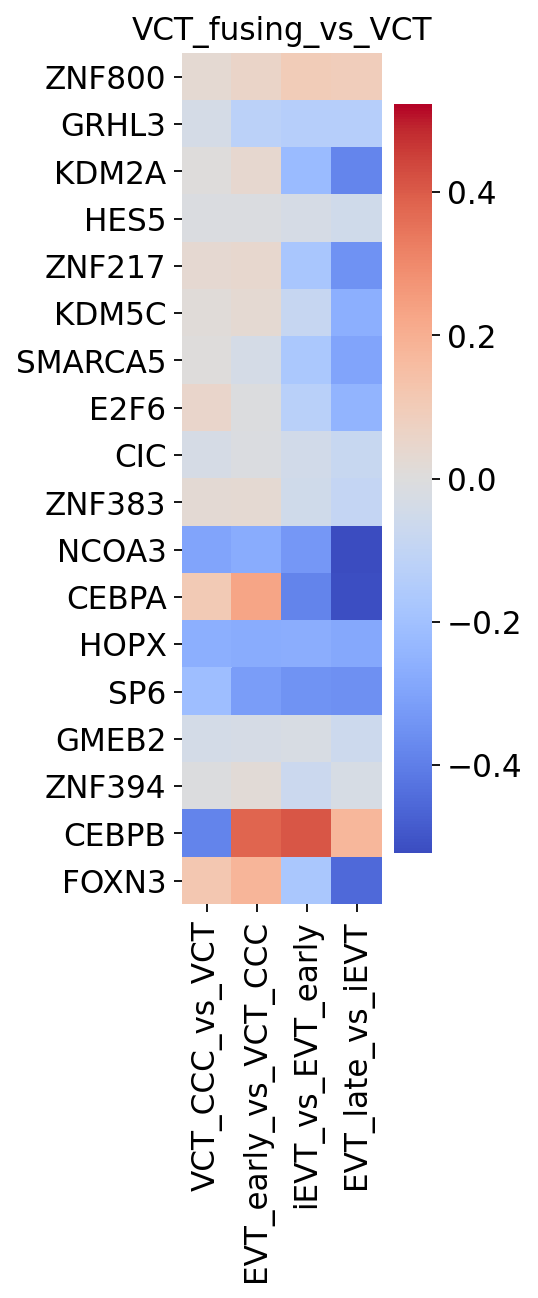

In [82]:
# saving some plots to have a look, unique TFs

order = ['VCT_CCC_vs_VCT',
         'EVT_early_vs_VCT_CCC',
         'iEVT_vs_EVT_early',
         'EVT_late_vs_iEVT'
        ]

for comparison in comparisons:
    print(comparison)
    
    plot_heatmap(TFs_to_visualise_dfs_scaled_unique[comparison].loc[:,order], 
                 #abs_color_lim=abs_limit
                )
    plt.title(comparison)
    plt.savefig('./figures/20211015_unique_TFs_plot_DE_limma_and_DA_DoRothEA_' + comparison + '_comparison.pdf',
               bbox_inches='tight')

In [87]:
TFs_to_visualise_dfs_scaled_unique['EVT_late_vs_iEVT']

EVT_late_vs_iEVT  iEVT_vs_EVT_early  EVT_early_vs_VCT_CCC  \
ATF5           -0.036046          -0.189954             -0.078928   
ZNF195          0.247380          -0.013404             -0.027562   
CREM           -0.039028          -0.186912             -0.217608   
NFKBIB          0.094482          -0.071797             -0.108873   
THAP3           0.218657          -0.051310             -0.006783   

        VCT_CCC_vs_VCT  SCT_vs_VCT_fusing  VCT_fusing_vs_VCT  
ATF5         -0.036136          -0.187471           0.093748  
ZNF195        0.085542          -0.184884          -0.156768  
CREM         -0.254252           0.468856           0.751319  
NFKBIB       -0.166819           0.229473           0.450228  
THAP3        -0.015787          -0.026436           0.002226

In [86]:
for comparison in comparisons:
    print(comparison)
    TFs_to_visualise_dfs_scaled[comparison].to_csv('./intermediate_files/20211015_TFs_DE_limma_and_DA_DoRothEA_' + comparison + '_comparison.csv')

EVT_late_vs_iEVT
iEVT_vs_EVT_early
EVT_early_vs_VCT_CCC
VCT_CCC_vs_VCT
SCT_vs_VCT_fusing
VCT_fusing_vs_VCT


In [91]:
# seeing how the TFs here align with those in vivo (acc to Cellphone-like DE analysis)
TFs_to_visualise_dfs_scaled_in_vivo = {}

comparisons_in_vivo = ['GC_vs_iEVT','eEVT_vs_EVT_3','iEVT_vs_EVT_3',
                        'EVT_3_vs_EVT_2','EVT_2_vs_EVT_1','EVT_1_vs_VCT_CCC',
                        'VCT_CCC_vs_VCT']

for comparison in comparisons_in_vivo:
    print(comparison)
    TFs_to_visualise_dfs_scaled_in_vivo[comparison] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/MFI_spatial/MFI_sc_sn_Integrated_analysis/TF_activities/intermediate_files/20211013_TFs_DE_limma_and_DA_DoRothEA_' + comparison + '_comparison.csv', 
                                                                   index_col=0)

GC_vs_iEVT
eEVT_vs_EVT_3
iEVT_vs_EVT_3
EVT_3_vs_EVT_2
EVT_2_vs_EVT_1
EVT_1_vs_VCT_CCC
VCT_CCC_vs_VCT


In [94]:
# so pre-GC are not really GC I guess... ?

for comparison_in_vitro in comparisons:
    print('in vitro comparison', comparison_in_vitro)
    
    for comparison_in_vivo in comparisons_in_vivo:
        print('common TFs (DE and DA) between current in vitro comparison', comparison_in_vitro, ' and', comparison_in_vivo, 'in vivo comparison',
              len(set(TFs_to_visualise_dfs_scaled_in_vivo[comparison_in_vivo].index) & set(TFs_to_visualise_dfs_scaled[comparison_in_vitro].index)))

in vitro comparison EVT_late_vs_iEVT
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and GC_vs_iEVT in vivo comparison 1
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and eEVT_vs_EVT_3 in vivo comparison 0
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and iEVT_vs_EVT_3 in vivo comparison 0
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and EVT_3_vs_EVT_2 in vivo comparison 1
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and EVT_2_vs_EVT_1 in vivo comparison 2
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and EVT_1_vs_VCT_CCC in vivo comparison 2
common TFs (DE and DA) between current in vitro comparison EVT_late_vs_iEVT  and VCT_CCC_vs_VCT in vivo comparison 3
in vitro comparison iEVT_vs_EVT_early
common TFs (DE and DA) between current in vitro comparison iEVT_vs_EVT_early  and GC_vs_iEVT in vivo compariso

In [88]:
TFs_to_visualise_dfs_scaled['EVT_late_vs_iEVT']

EVT_late_vs_iEVT  iEVT_vs_EVT_early  EVT_early_vs_VCT_CCC  \
GTF3A           0.268569           0.177933              0.018737   
ATF5           -0.036046          -0.189954             -0.078928   
LYAR            0.248754          -0.048206             -0.116590   
MLX             0.367405           0.088729             -0.046395   
ZNF195          0.247380          -0.013404             -0.027562   
TBPL1           0.132854          -0.021429             -0.050550   
CREM           -0.039028          -0.186912             -0.217608   
DNAJC1          0.700963           0.364260              0.132224   
BATF2           0.270518           0.064146             -0.032714   
STAT1           0.533326           0.219269             -0.146132   
NFKBIB          0.094482          -0.071797             -0.108873   
THAP3           0.218657          -0.051310             -0.006783   
SP110           0.504828           0.138245             -0.048715   
ZNF32           0.331692           0.089485             -0.069606   

        VCT_CCC_vs_VCT  SCT_vs_VCT_fusing  VCT_fusing_vs_VCT  
GTF3A         0.031827          -0.369978          -0.428743  
ATF5         -0.036136          -0.187471           0.093748  
LYAR         -0.086441          -0.215919          -0.066562  
MLX          -0.144456           0.000393           0.096748  
ZNF195        0.085542          -0.184884          -0.156768  
TBPL1        -0.110119           0.114339           0.863619  
CREM         -0.254252           0.468856           0.751319  
DNAJC1       -0.327908           0.282039          -0.100941  
BATF2        -0.037896          -0.066435          -0.061016  
STAT1        -0.137083           0.031903          -0.257914  
NFKBIB       -0.166819           0.229473           0.450228  
THAP3        -0.015787          -0.026436           0.002226  
SP110        -0.072588          -0.121224           0.055257  
ZNF32        -0.022736          -0.191617          -0.226932

In [ ]:
# trying to prioritise regulons somehow?

In [89]:
TF_activities['EVT_late_vs_iEVT']

Regulon  Size        NES        p.value            FDR score  \
GTF3A_E    GTF3A_E  1209  23.723408  2.067814e-124  2.863922e-121     E   
PHF5A_E    PHF5A_E  1701  20.741725   1.456099e-95   1.008348e-92     E   
THAP4_E    THAP4_E  1144  17.091742   1.709895e-65   7.894017e-63     E   
NFKBIB_E  NFKBIB_E   805  13.704368   9.559612e-43   3.310016e-40     E   
ZNF787_E  ZNF787_E   660  13.616954   3.175379e-42   8.795800e-40     E   
...            ...   ...        ...            ...            ...   ...   
ZBTB32_E  ZBTB32_E    78   0.004895   9.960941e-01   9.989792e-01     E   
SCRT2_E    SCRT2_E   364  -0.002276   9.981841e-01   9.996795e-01     E   
DMRTC2_E  DMRTC2_E    97  -0.001348   9.989241e-01   9.996795e-01     E   
FOXO6_D    FOXO6_D    35  -0.001306   9.989578e-01   9.996795e-01     D   
SOHLH1_E  SOHLH1_E    58   0.000057   9.999543e-01   9.999543e-01     E   

         TF_name  
GTF3A_E    GTF3A  
PHF5A_E    PHF5A  
THAP4_E    THAP4  
NFKBIB_E  NFKBIB  
ZNF787_E  ZNF787  
...          ...  
ZBTB32_E  ZBTB32  
SCRT2_E    SCRT2  
DMRTC2_E  DMRTC2  
FOXO6_D    FOXO6  
SOHLH1_E  SOHLH1  

[1385 rows x 7 columns]

In [58]:
TFs_upregulated_per_comparison['pre-GC_vs_iEVT']['Avg_expr'].value_counts()

not_enough_cells_expr_limma    100
0.0                             82
0.002268                         2
0.002454                         2
0.040952                         1
                              ... 
0.057622                         1
0.0094                           1
0.385369                         1
0.433657                         1
0.036113                         1
Name: Avg_expr, Length: 662, dtype: int64

In [51]:
DEGs_significant_upreg_TFs['pre-GC_vs_iEVT'].shape

(362, 7)

In [54]:
DEGs_significant_upreg_TFs['pre-GC_vs_iEVT']

logFC       P.Value     adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                            
ELK3      0.050300  1.432382e-03  5.656830e-03         0.148101      0.068865   
ZNF208    0.013814  1.071537e-04  5.281279e-04         0.019145      0.003609   
SOX4      0.313175  5.385102e-09  4.818886e-08         1.473836      0.958236   
KMT2A     0.159378  8.524539e-09  7.460504e-08         0.403618      0.224550   
FOXN2     0.136677  2.689868e-09  2.511271e-08         0.305624      0.154394   
SP3       0.085893  1.652190e-03  6.420773e-03         0.350268      0.230239   
HOXB3     0.028225  1.754425e-06  1.145162e-05         0.039908      0.008461   
ZNF280C   0.042592  2.882932e-07  2.102570e-06         0.064851      0.016472   
ZBED6     0.012557  4.310728e-03  1.520085e-02         0.018030      0.005111   
HOXB5     0.006512  1.999696e-05  1.107565e-04         0.006790      0.000367   
ZNF493    0.075696  5.842128e-08  4.652573e-07         0.128424      0.052216   
ZNF518B   0.048187  1.573439e-02  4.796324e-02         0.165933      0.111710   
ARX       0.020618  4.526165e-03  1.585690e-02         0.036629      0.014483   
GRHL1     0.408651  3.158336e-24  9.016722e-23         1.016575      0.609635   
ZBTB18    0.023345  3.842949e-04  1.700328e-03         0.038749      0.009785   
TONSL     0.020495  1.650790e-03  6.416534e-03         0.032151      0.010388   
ZNF418    0.015302  1.395392e-06  9.227419e-06         0.018776      0.002632   
ZNF692    0.091964  9.087533e-11  1.011257e-09         0.146752      0.054020   
SMAD2     0.066124  1.307434e-02  4.080408e-02         0.315503      0.222202   
PAX6      0.008307  3.901236e-04  1.723907e-03         0.009269      0.000821   
ARID3A    0.273194  1.422995e-12  1.905119e-11         2.121410      1.925971   
ZNF600    0.046311  1.618190e-03  6.308778e-03         0.098425      0.055443   
ZNF845    0.030858  3.611872e-04  1.607710e-03         0.048485      0.019611   
MYCN      0.366478  1.916751e-17  3.789199e-16         1.126065      0.648024   
TFCP2     0.040066  8.515445e-03  2.787926e-02         0.116552      0.064501   
ZNF76     0.070502  6.039204e-08  4.796602e-07         0.129253      0.046571   
ATF6B     0.180321  8.298608e-12  1.029147e-10         0.415939      0.222607   
RERE      0.123060  4.965823e-05  2.585726e-04         0.461313      0.290498   
BNC1      0.002363  5.085528e-06  3.114209e-05         0.002423      0.000051   
ZNF655    0.306455  6.931363e-28  2.367415e-26         0.581718      0.237373   
ZNF248    0.053509  3.665258e-06  2.295416e-05         0.087641      0.033815   
ZFP30     0.031787  1.361320e-03  5.399886e-03         0.057622      0.026053   
ZNF532    0.050398  1.308673e-20  3.117020e-19         0.062163      0.007056   
PRDM6     0.013139  5.219159e-07  3.685641e-06         0.014505      0.001356   
MZF1      0.059948  2.545652e-08  2.103389e-07         0.097526      0.029948   
ZNF266    0.024825  2.765378e-03  1.019191e-02         0.045140      0.017852   
ARNTL2    0.032629  5.597708e-04  2.389880e-03         0.063247      0.024865   
DMTF1     0.119717  4.203787e-11  4.852760e-10         0.206215      0.087672   
PBRM1     0.285007  4.073346e-23  1.092100e-21         0.563186      0.258621   
ZNF211    0.018457  1.435479e-02  4.431251e-02         0.036819      0.014714   
ZNF169    0.024070  4.899991e-04  2.118655e-03         0.033201      0.011965   
ZGPAT     0.008044  1.328585e-02  4.139555e-02         0.010824      0.002766   
ZNF721    0.049003  9.218346e-03  2.992962e-02         0.137915      0.093795   
HIF1A     0.243628  2.034084e-10  2.167943e-09         0.909478      0.552167   
ZNF544    0.031563  9.123767e-03  2.964580e-02         0.069082      0.039594   
ZNF714    0.062772  4.667713e-04  2.027475e-03         0.122013      0.084235   
ZBTB48    0.034488  3.880150e-03  1.385634e-02         0.082020      0.037858   
PSPC1     0.105296  2.694018e-03  9.959062e-

In [46]:
TF_activities_upreg['pre-GC_vs_iEVT']

Regulon  Size        NES        p.value            FDR score  \
KDM2A_E      KDM2A_E   597  23.594266  4.413629e-123  1.222575e-120     E   
PBRM1_E      PBRM1_E  1036  21.424853  7.838167e-102   1.550837e-99     E   
RC3H2_E      RC3H2_E   886  21.172970   1.695314e-99   2.935012e-97     E   
ZNF142_E    ZNF142_E   530  19.925026   2.469190e-88   3.419828e-86     E   
MIER3_E      MIER3_E   477  19.837995   1.399292e-87   1.761836e-85     E   
...              ...   ...        ...            ...            ...   ...   
KLF16_E      KLF16_E   763   2.185829   2.882815e-02   4.664368e-02     E   
ZSCAN31_E  ZSCAN31_E   432   2.183367   2.900881e-02   4.688122e-02     E   
EMX2_E        EMX2_E   421   2.173282   2.975909e-02   4.803769e-02     E   
DNAJC2_E    DNAJC2_E  1220   2.166583   3.026668e-02   4.880017e-02     E   
NKX2-5_E    NKX2-5_E   641   2.164337   3.043849e-02   4.902012e-02     E   

           TF_name  
KDM2A_E      KDM2A  
PBRM1_E      PBRM1  
RC3H2_E      RC3H2  
ZNF142_E    ZNF142  
MIER3_E      MIER3  
...            ...  
KLF16_E      KLF16  
ZSCAN31_E  ZSCAN31  
EMX2_E        EMX2  
DNAJC2_E    DNAJC2  
NKX2-5_E    NKX2-5  

[710 rows x 7 columns]